In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
import networkx as nx
import ujson
import os


**plot_dendrogram(distance_matrix, labels, linkage="single", truncate_level=-1, figure_size=(20, 15), dpi=300, savefig=False, fig_name="output.png")**

Perform hierarchical clustering on given distance matrix, and draw a dendrogram of the clustering result.

***Parameters:***

**distance_matrix**: the distance matrix to perform hierarchical clustering on.

**labels**: A list of labels corresponding to the distance matrix. The order of labels should be the same as the indices of distance matrix.

**linkage**: Linkage type, default to "single". Can be "single", "average", and "complete".

**truncate_level**: Draw dendrogram with at most "truncate_level" levels. -1 to show the complete dendrogram. Default to -1.

**figure_size**: Figure size of the output dendrogram. Default to (20, 15).

**dpi**: DPI of the output dendrogram figure. Default to 300.

**savefig**: Whether or not to save the output figure. Default to false.

**fig_name**: Name of the saved output figure. Only used when ```savefig=True```. Default to "output.png".


In [2]:
def plot_dendrogram(distance_matrix, labels, linkage="single",
                    truncate_level=-1, figure_size=(20, 15),
                    dpi=300, savefig=False, fig_name="output.png"):
    
    cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',
                                 compute_full_tree=True, linkage=linkage, compute_distances=True)
    cl.fit(distance_matrix)
    
    kwarg = {"truncate_mode": "level", "p": truncate_level, "orientation": "right", "labels": labels}
    
    n_samples = len(cl.labels_)
    counts = np.zeros(cl.children_.shape[0])
    plt.figure(figsize=figure_size, dpi=dpi)
    for i, merge in enumerate(cl.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

        linkage_matrix = np.column_stack(
            [cl.children_, cl.distances_, counts]
        ).astype(float)
        dendrogram(linkage_matrix, **kwarg)
        pass
    
    if savefig is True:
        plt.savefig(fig_name)
        

## Distance Functions
**Terminologies**: Similarity Matrix: Higher value means higher similarity (closer distance). Distance Matrix: Higher value means higher distance (less similar).

***d1***: input: similarity matrix, base number $r > 1$. output: distance matrix. 

$$distance = \frac{1}{r^{similarity}}$$


In [3]:
def d1(similarity: np.ndarray, r: float) -> np.ndarray:
    ret = 1/np.power(r, similarity)
    np.fill_diagonal(ret, 0)
    return ret

In [4]:
data_dir = "../data/"

# Hierarchical Clustering with collaboration distance

**Collaboration distance**

"Collaboration distance" is obtained from a tool on https://mathscinet.ams.org/.

This distance represents minimumly how many papers away two authors are. For example, if A coauthored a paper with B, but A worked with C, C worked with D, and D worked with B, then the collaboration distance between A and B would be 3 (A-C-D-B). Similarly, collaboration distance between A and C is 1, between A and D is 2.

In [9]:
f_collab_distance = os.path.join(data_dir, "collaboration_distances.csv")
df_collab_distance = pd.read_csv(f_collab_distance)
faculties = list(df_collab_distance.columns)    # Obtain a list of facauty names
faculties.pop(0)


'Unnamed: 0'

In [7]:
mat_collab_distance = df_collab_distance[faculties].to_numpy()


### Dendrograms of Different Linkages

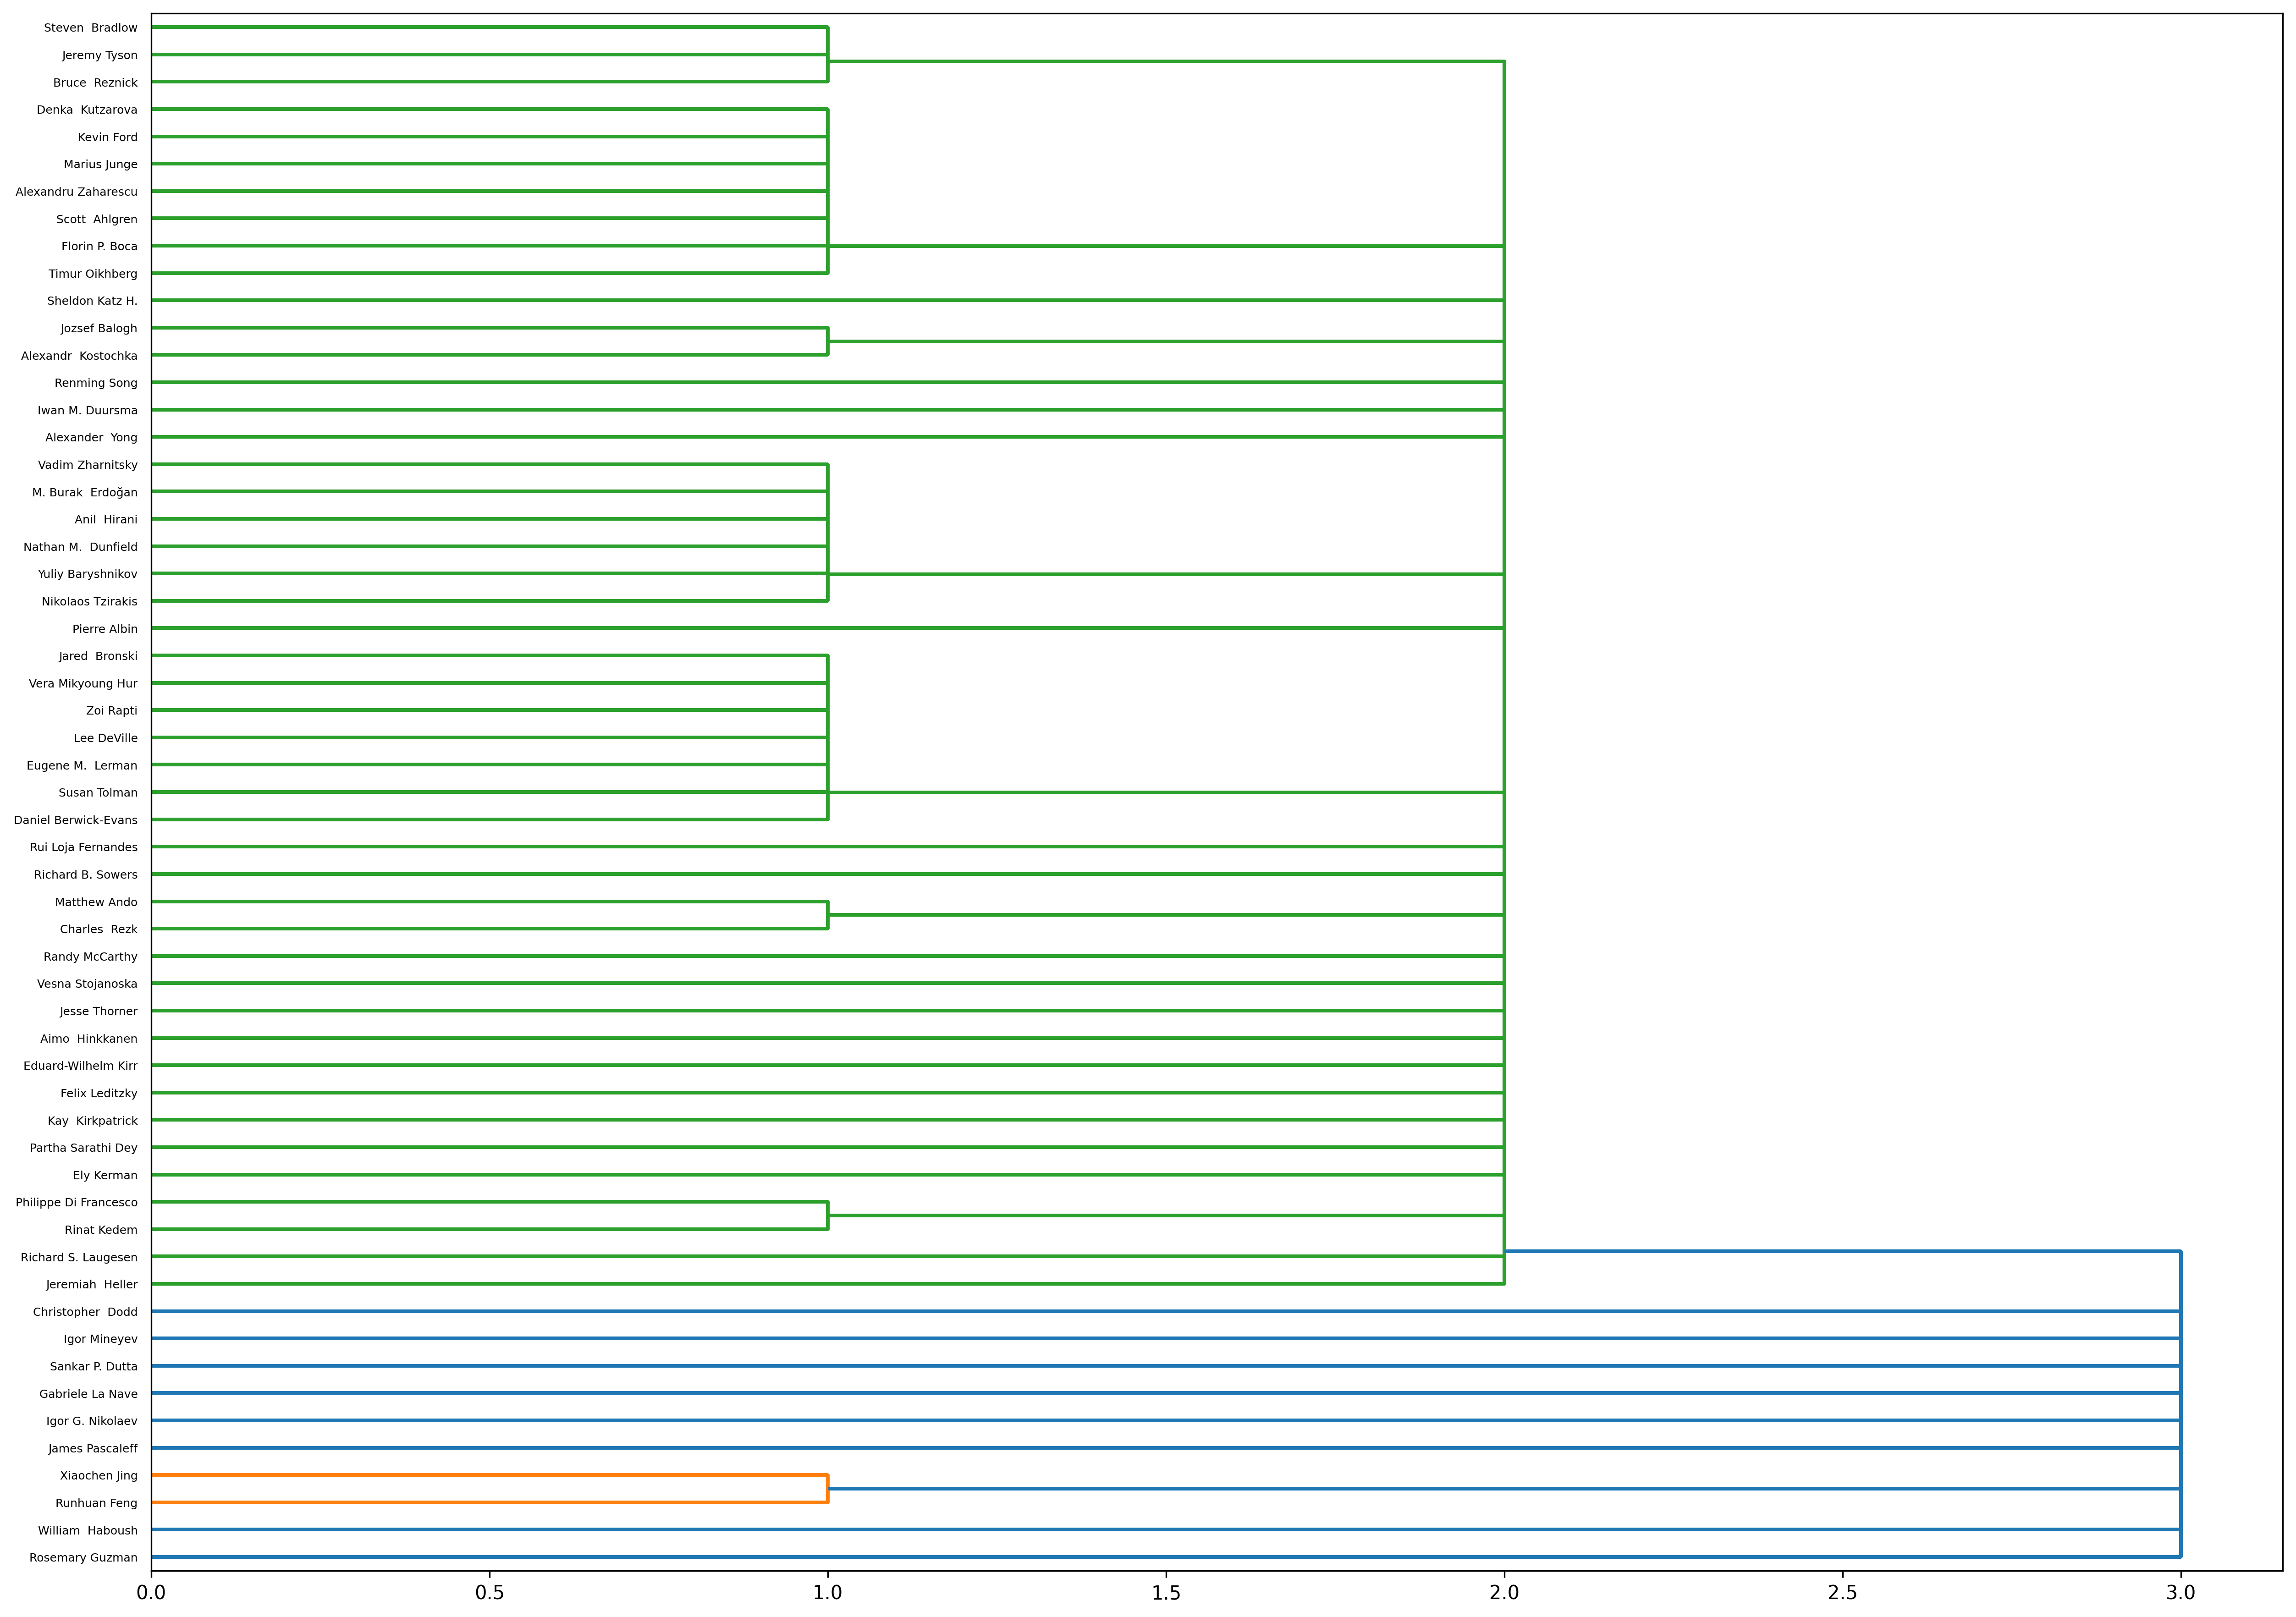

In [8]:
# Single linkage
plot_dendrogram(mat_collab_distance, faculties, linkage="single")


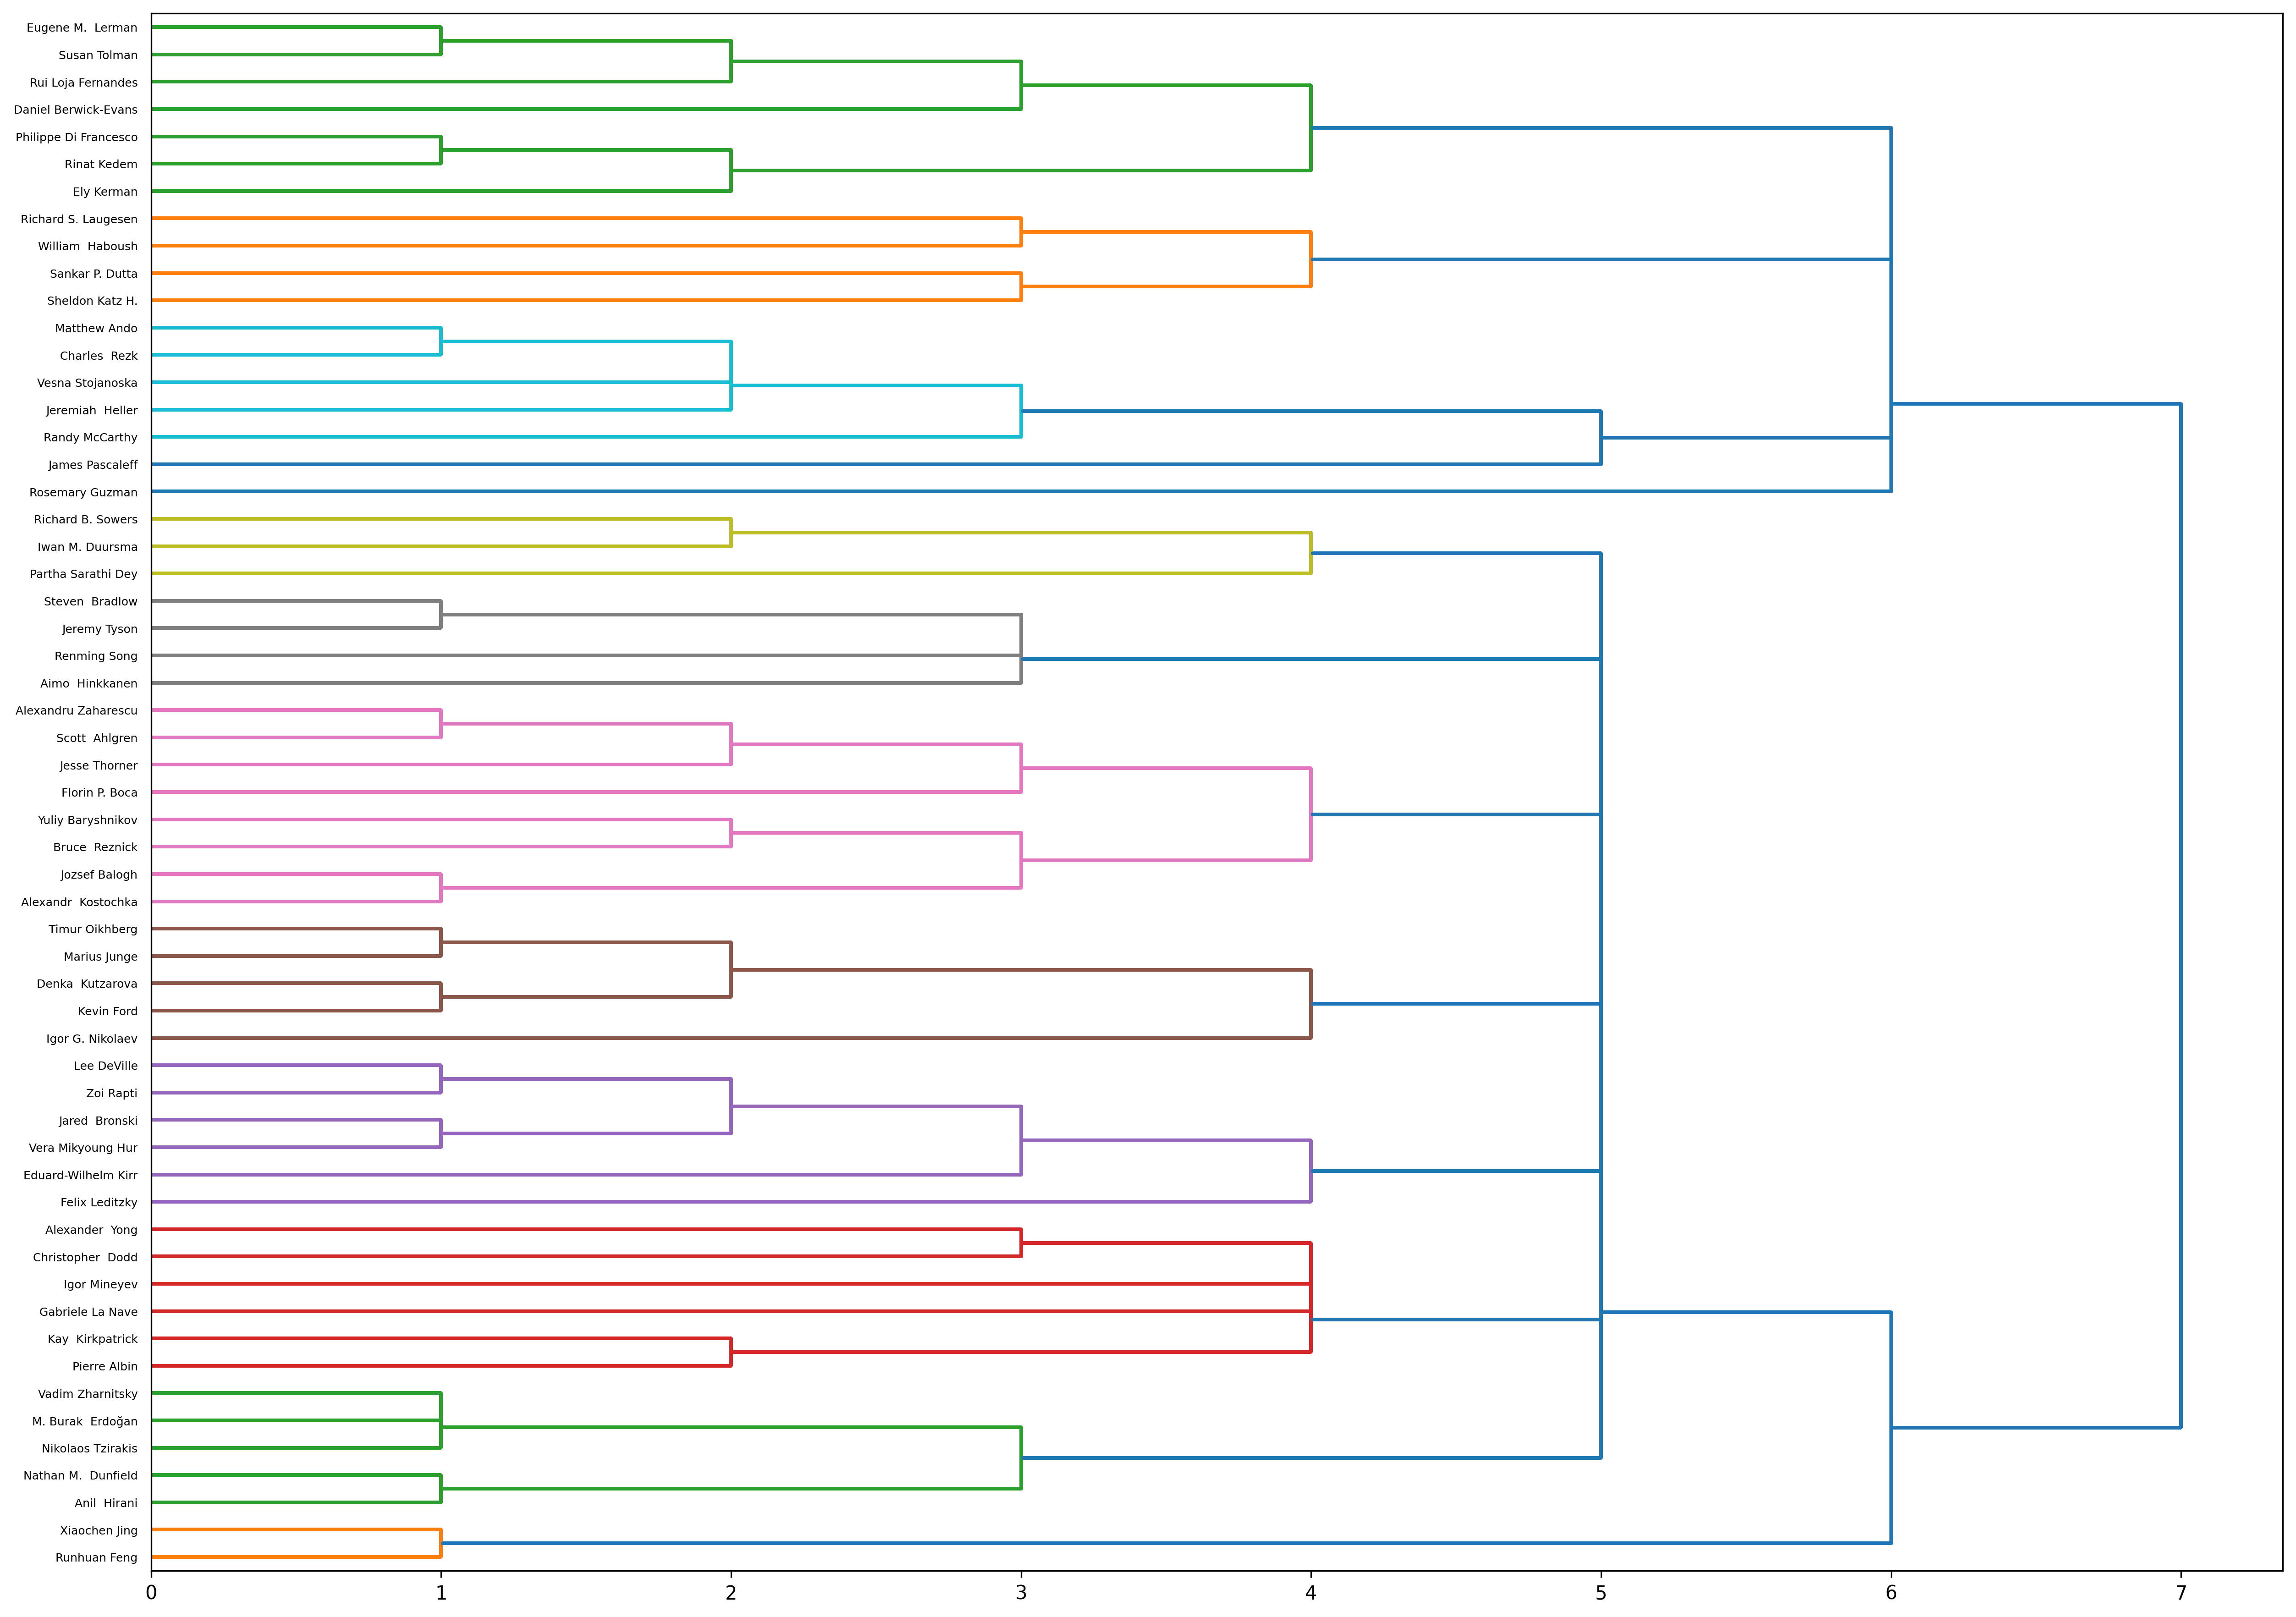

In [10]:
# Complete
plot_dendrogram(mat_collab_distance, faculties, linkage="complete")

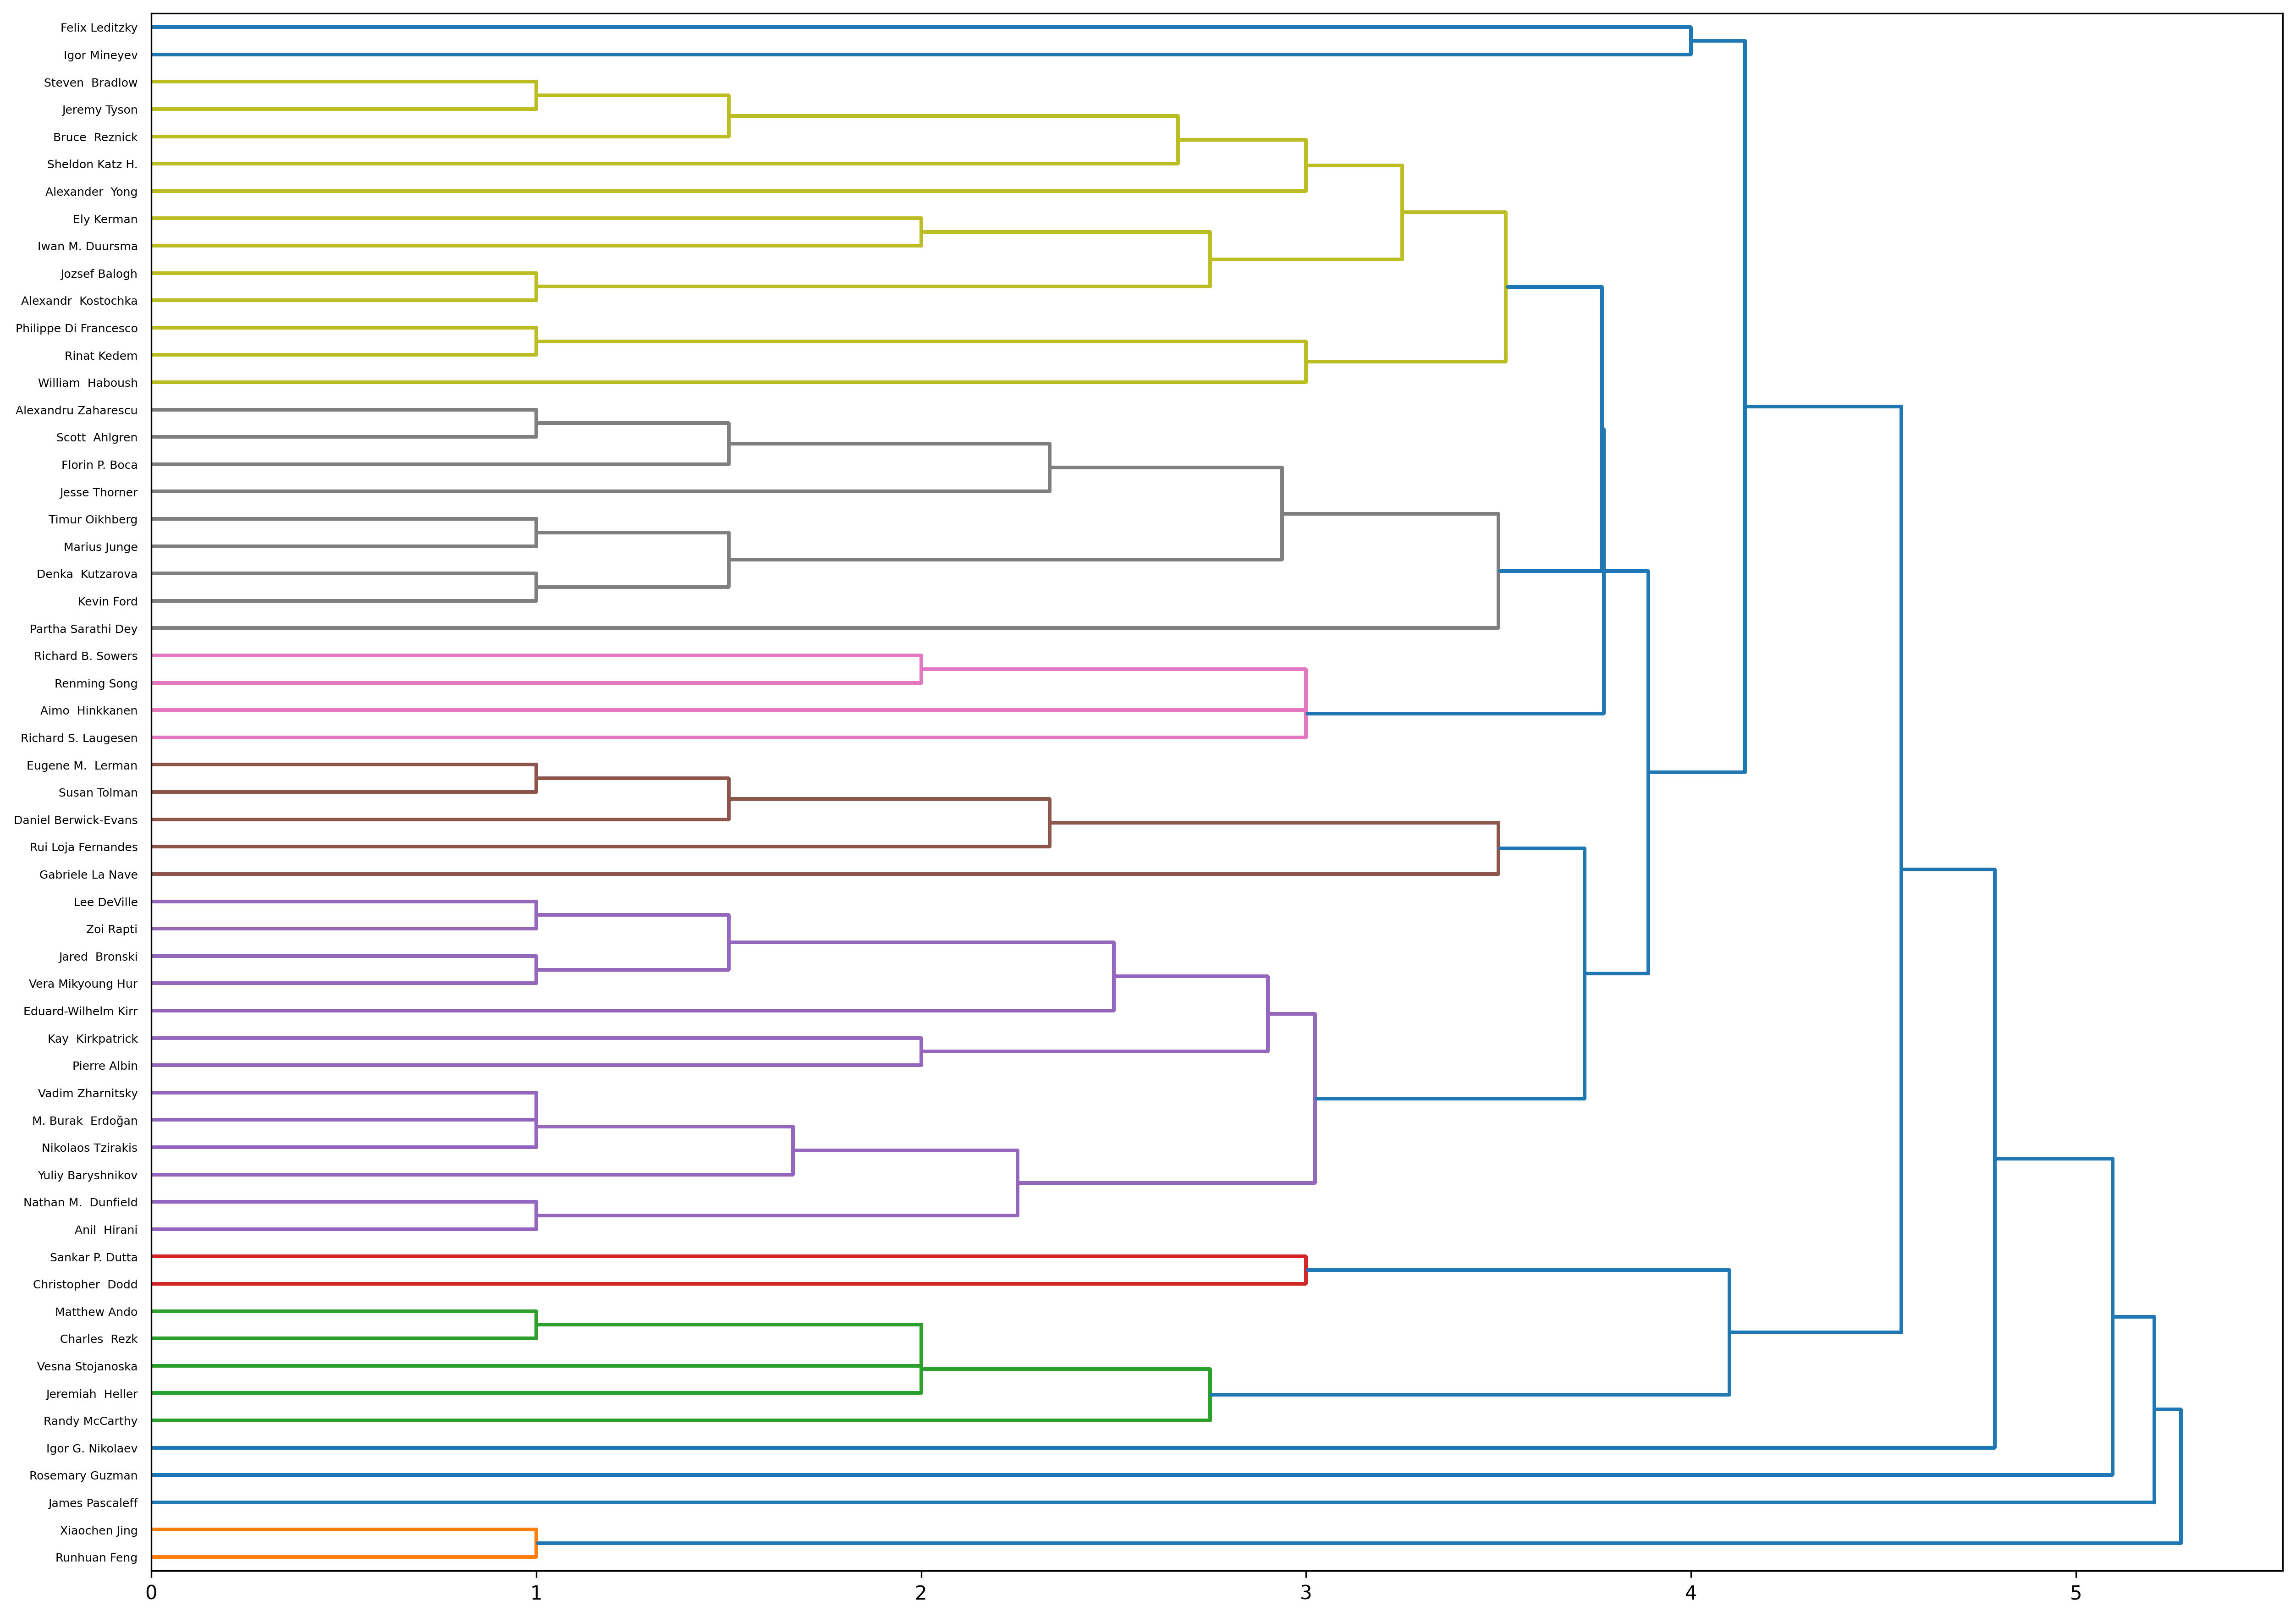

In [11]:
# Average
plot_dendrogram(mat_collab_distance, faculties, linkage="average")


# Clustering with # of joint publication

**Number of Joint Publication**

This data simply represents how many paper each pair of faculties co-authored.

In [16]:
f_joint_pub = os.path.join(data_dir, "joint_publication.json")
with open(f_joint_pub) as file:
    d_joint_pub = ujson.load(file)

In [21]:
# Construct similarity matrix and distance matrix
num_ppl = len(faculties)
sim_joint_pub = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_pub.items():
    sim_joint_pub[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_pub += sim_joint_pub.T
dist_joint_pub = d1(sim_joint_pub, 2)


### Dendrogram of different linkages (using joint publication number)

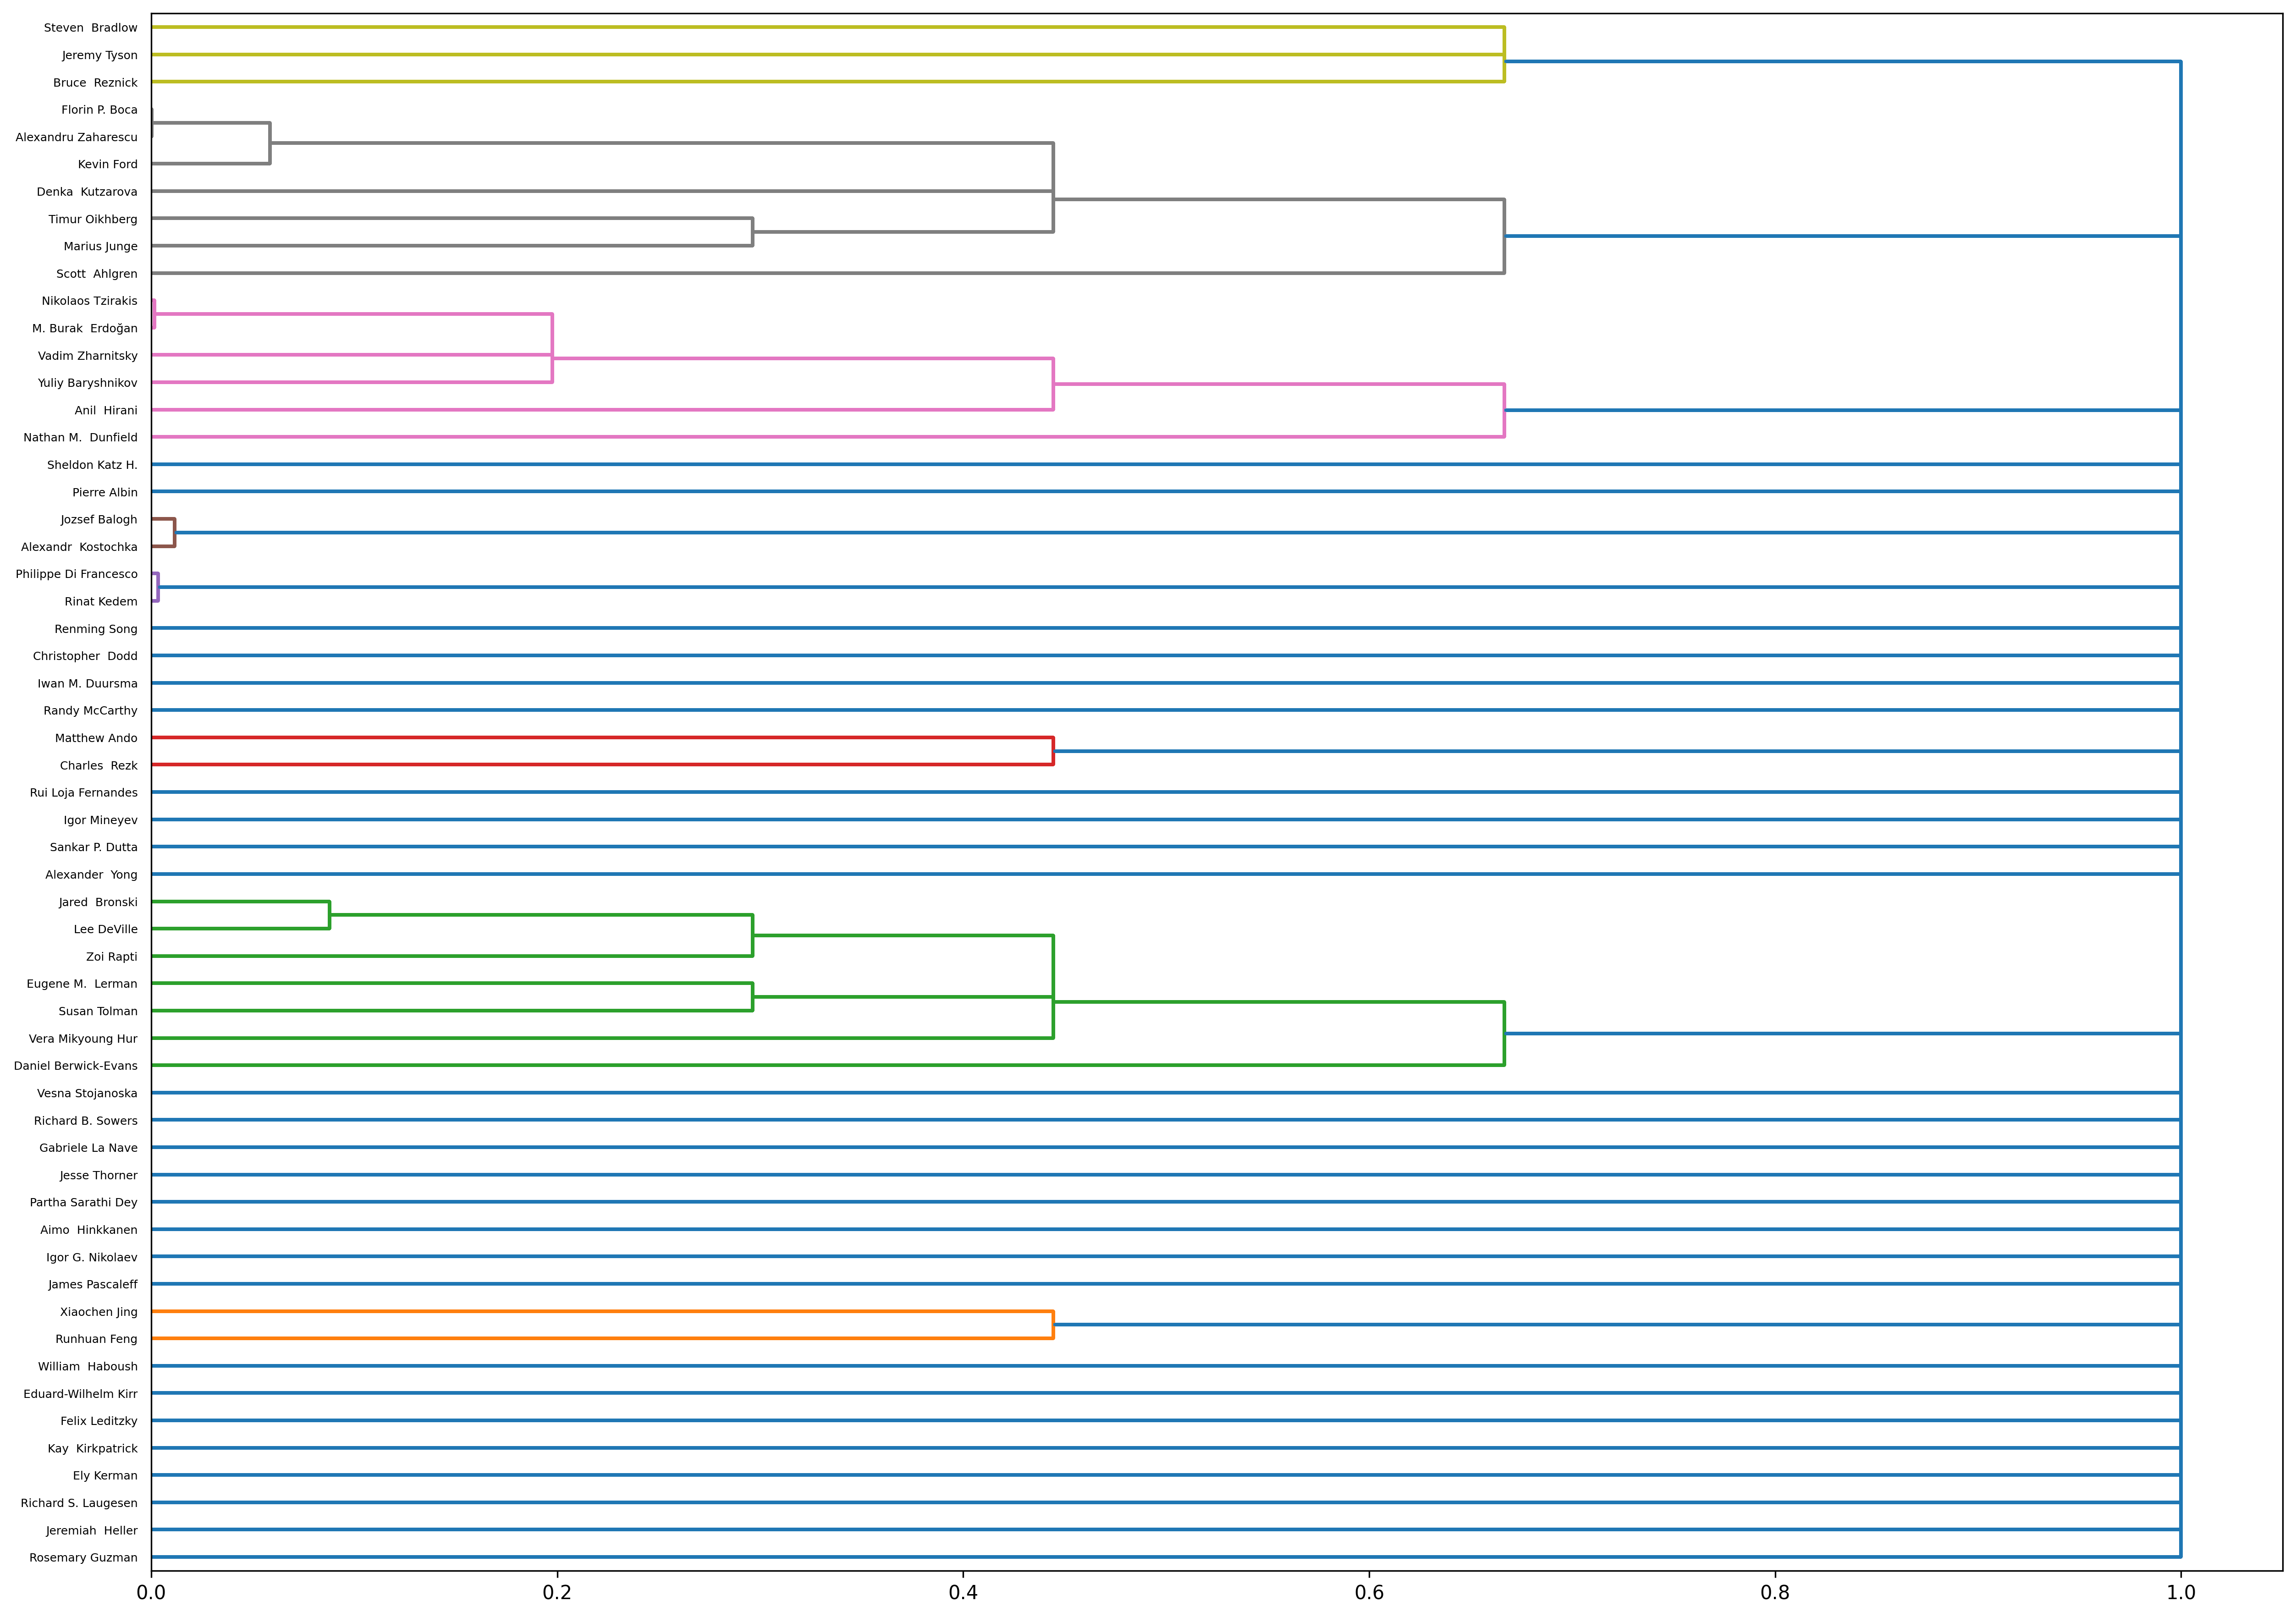

In [14]:
# Single
plot_dendrogram(dist_joint_pub, faculties, linkage="single")

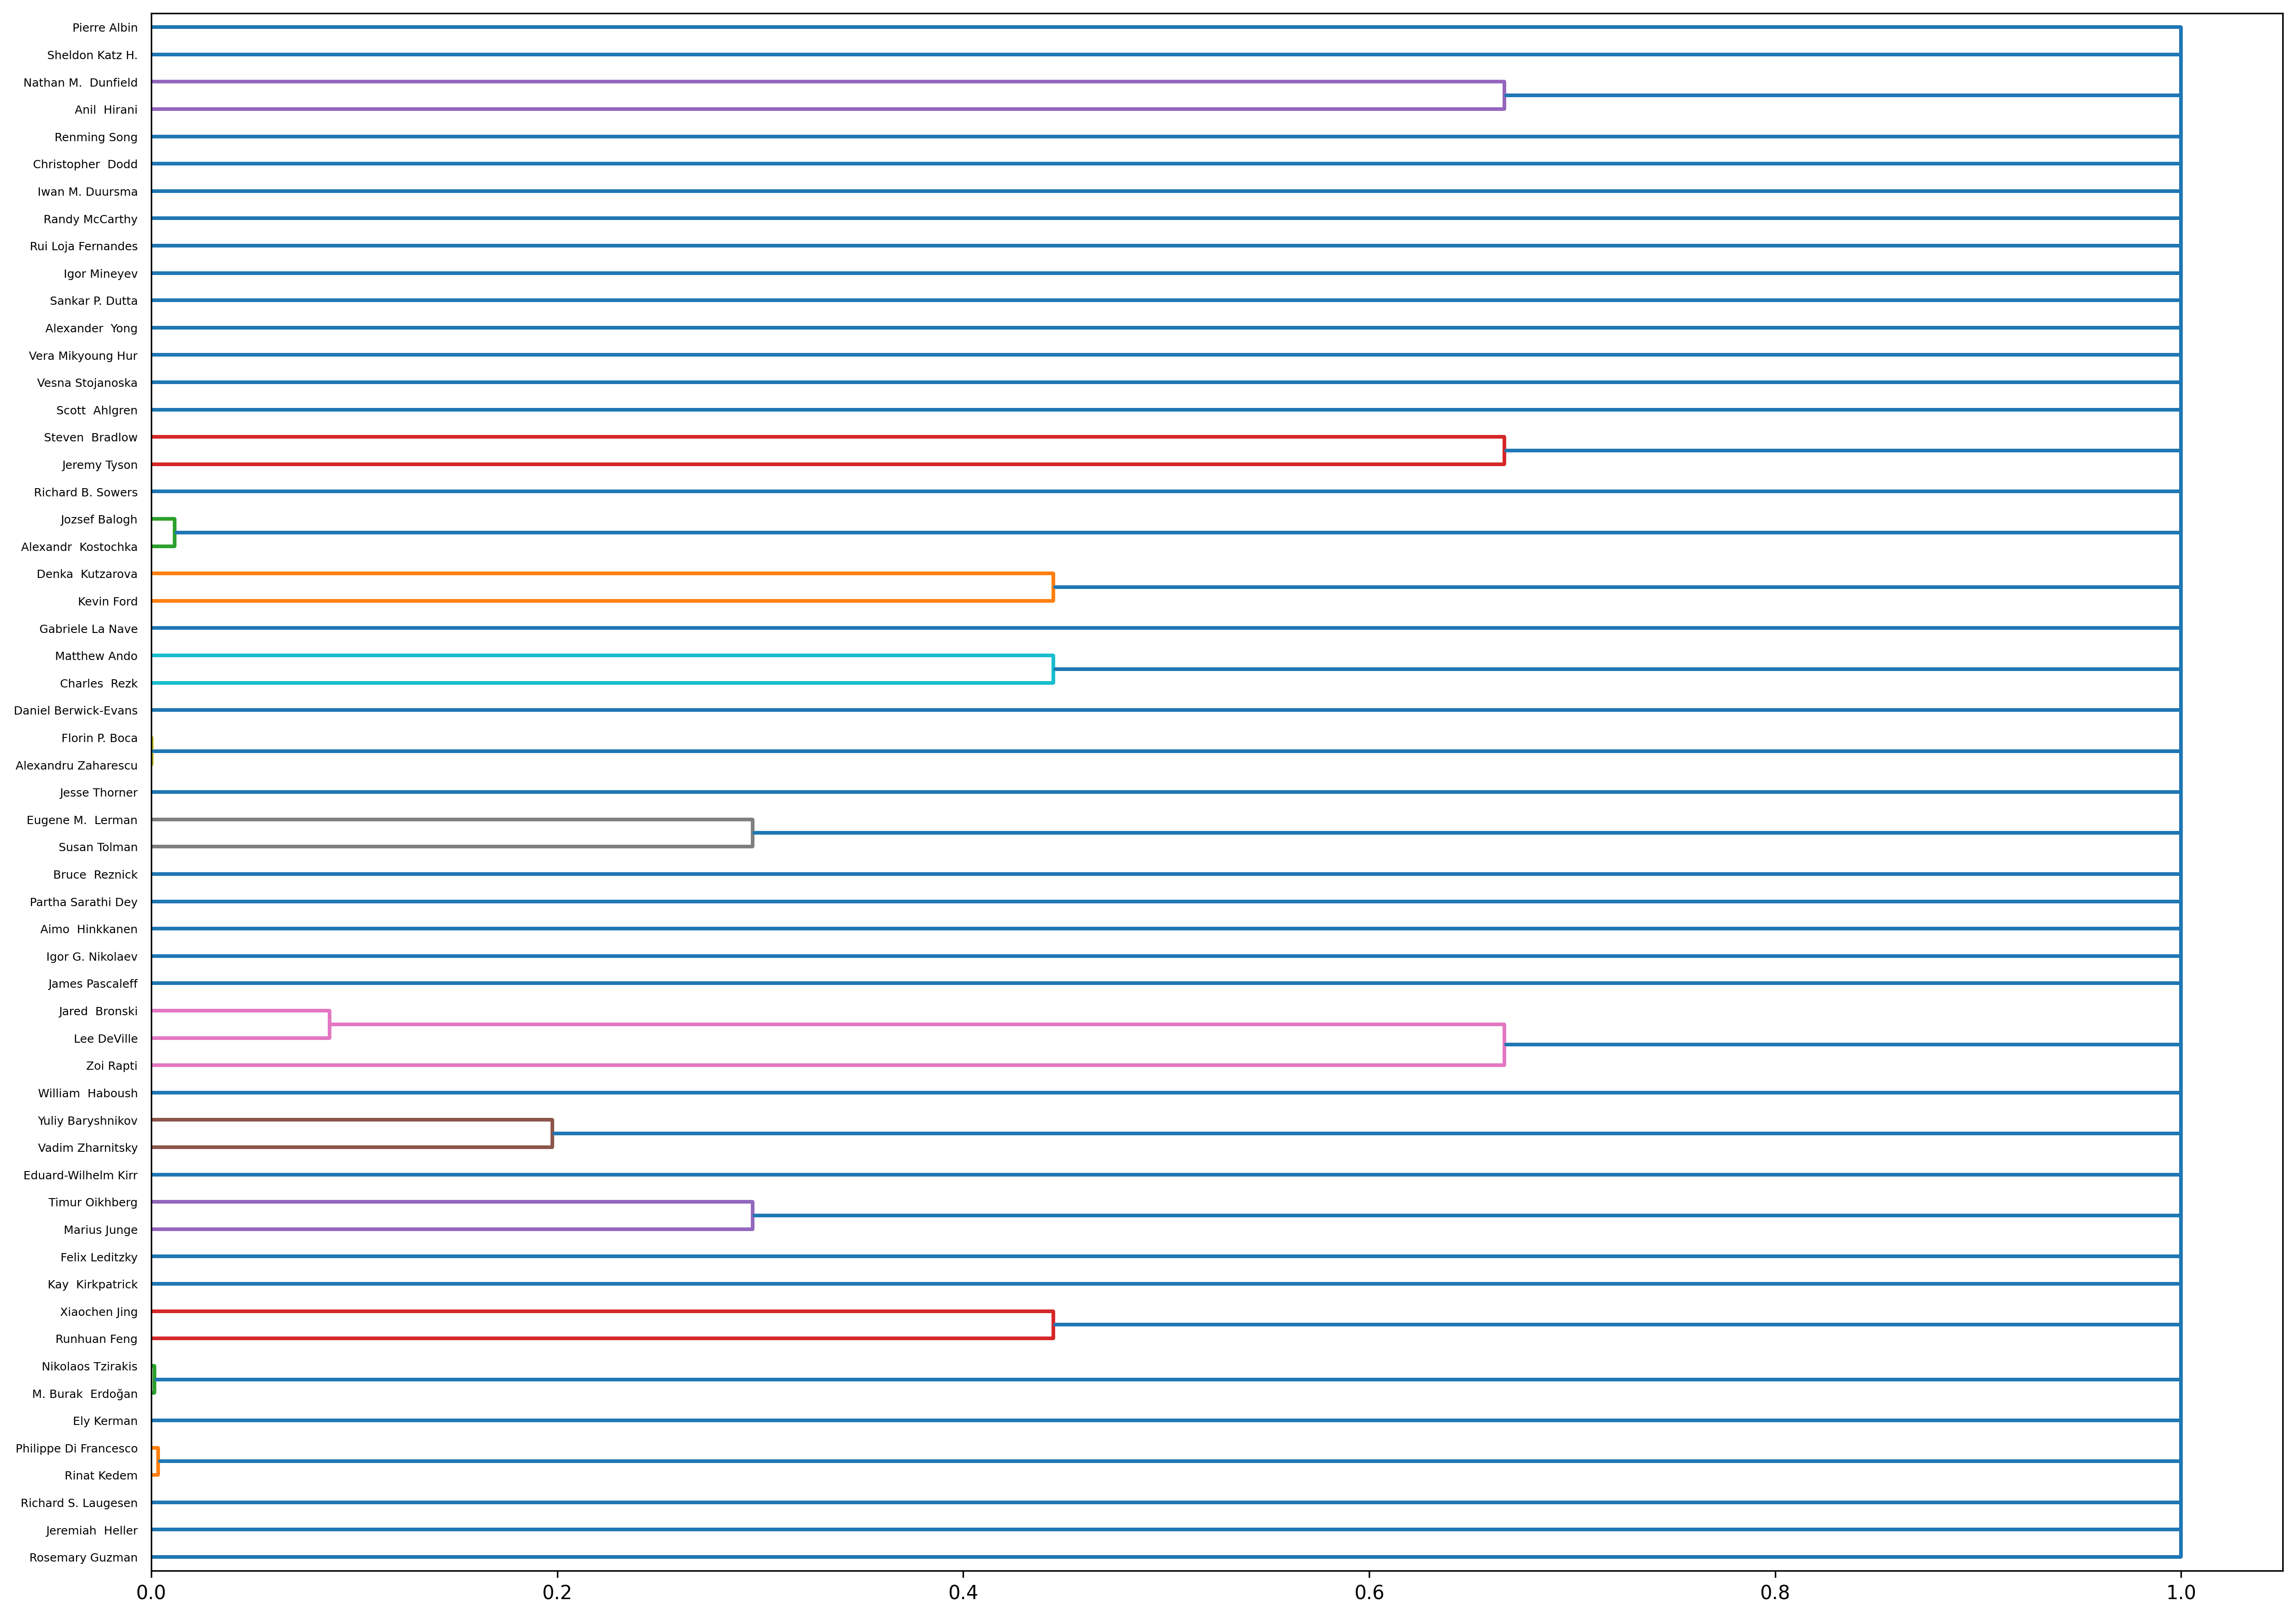

In [11]:
# Complete
plot_dendrogram(dist_joint_pub, faculties, linkage="complete")


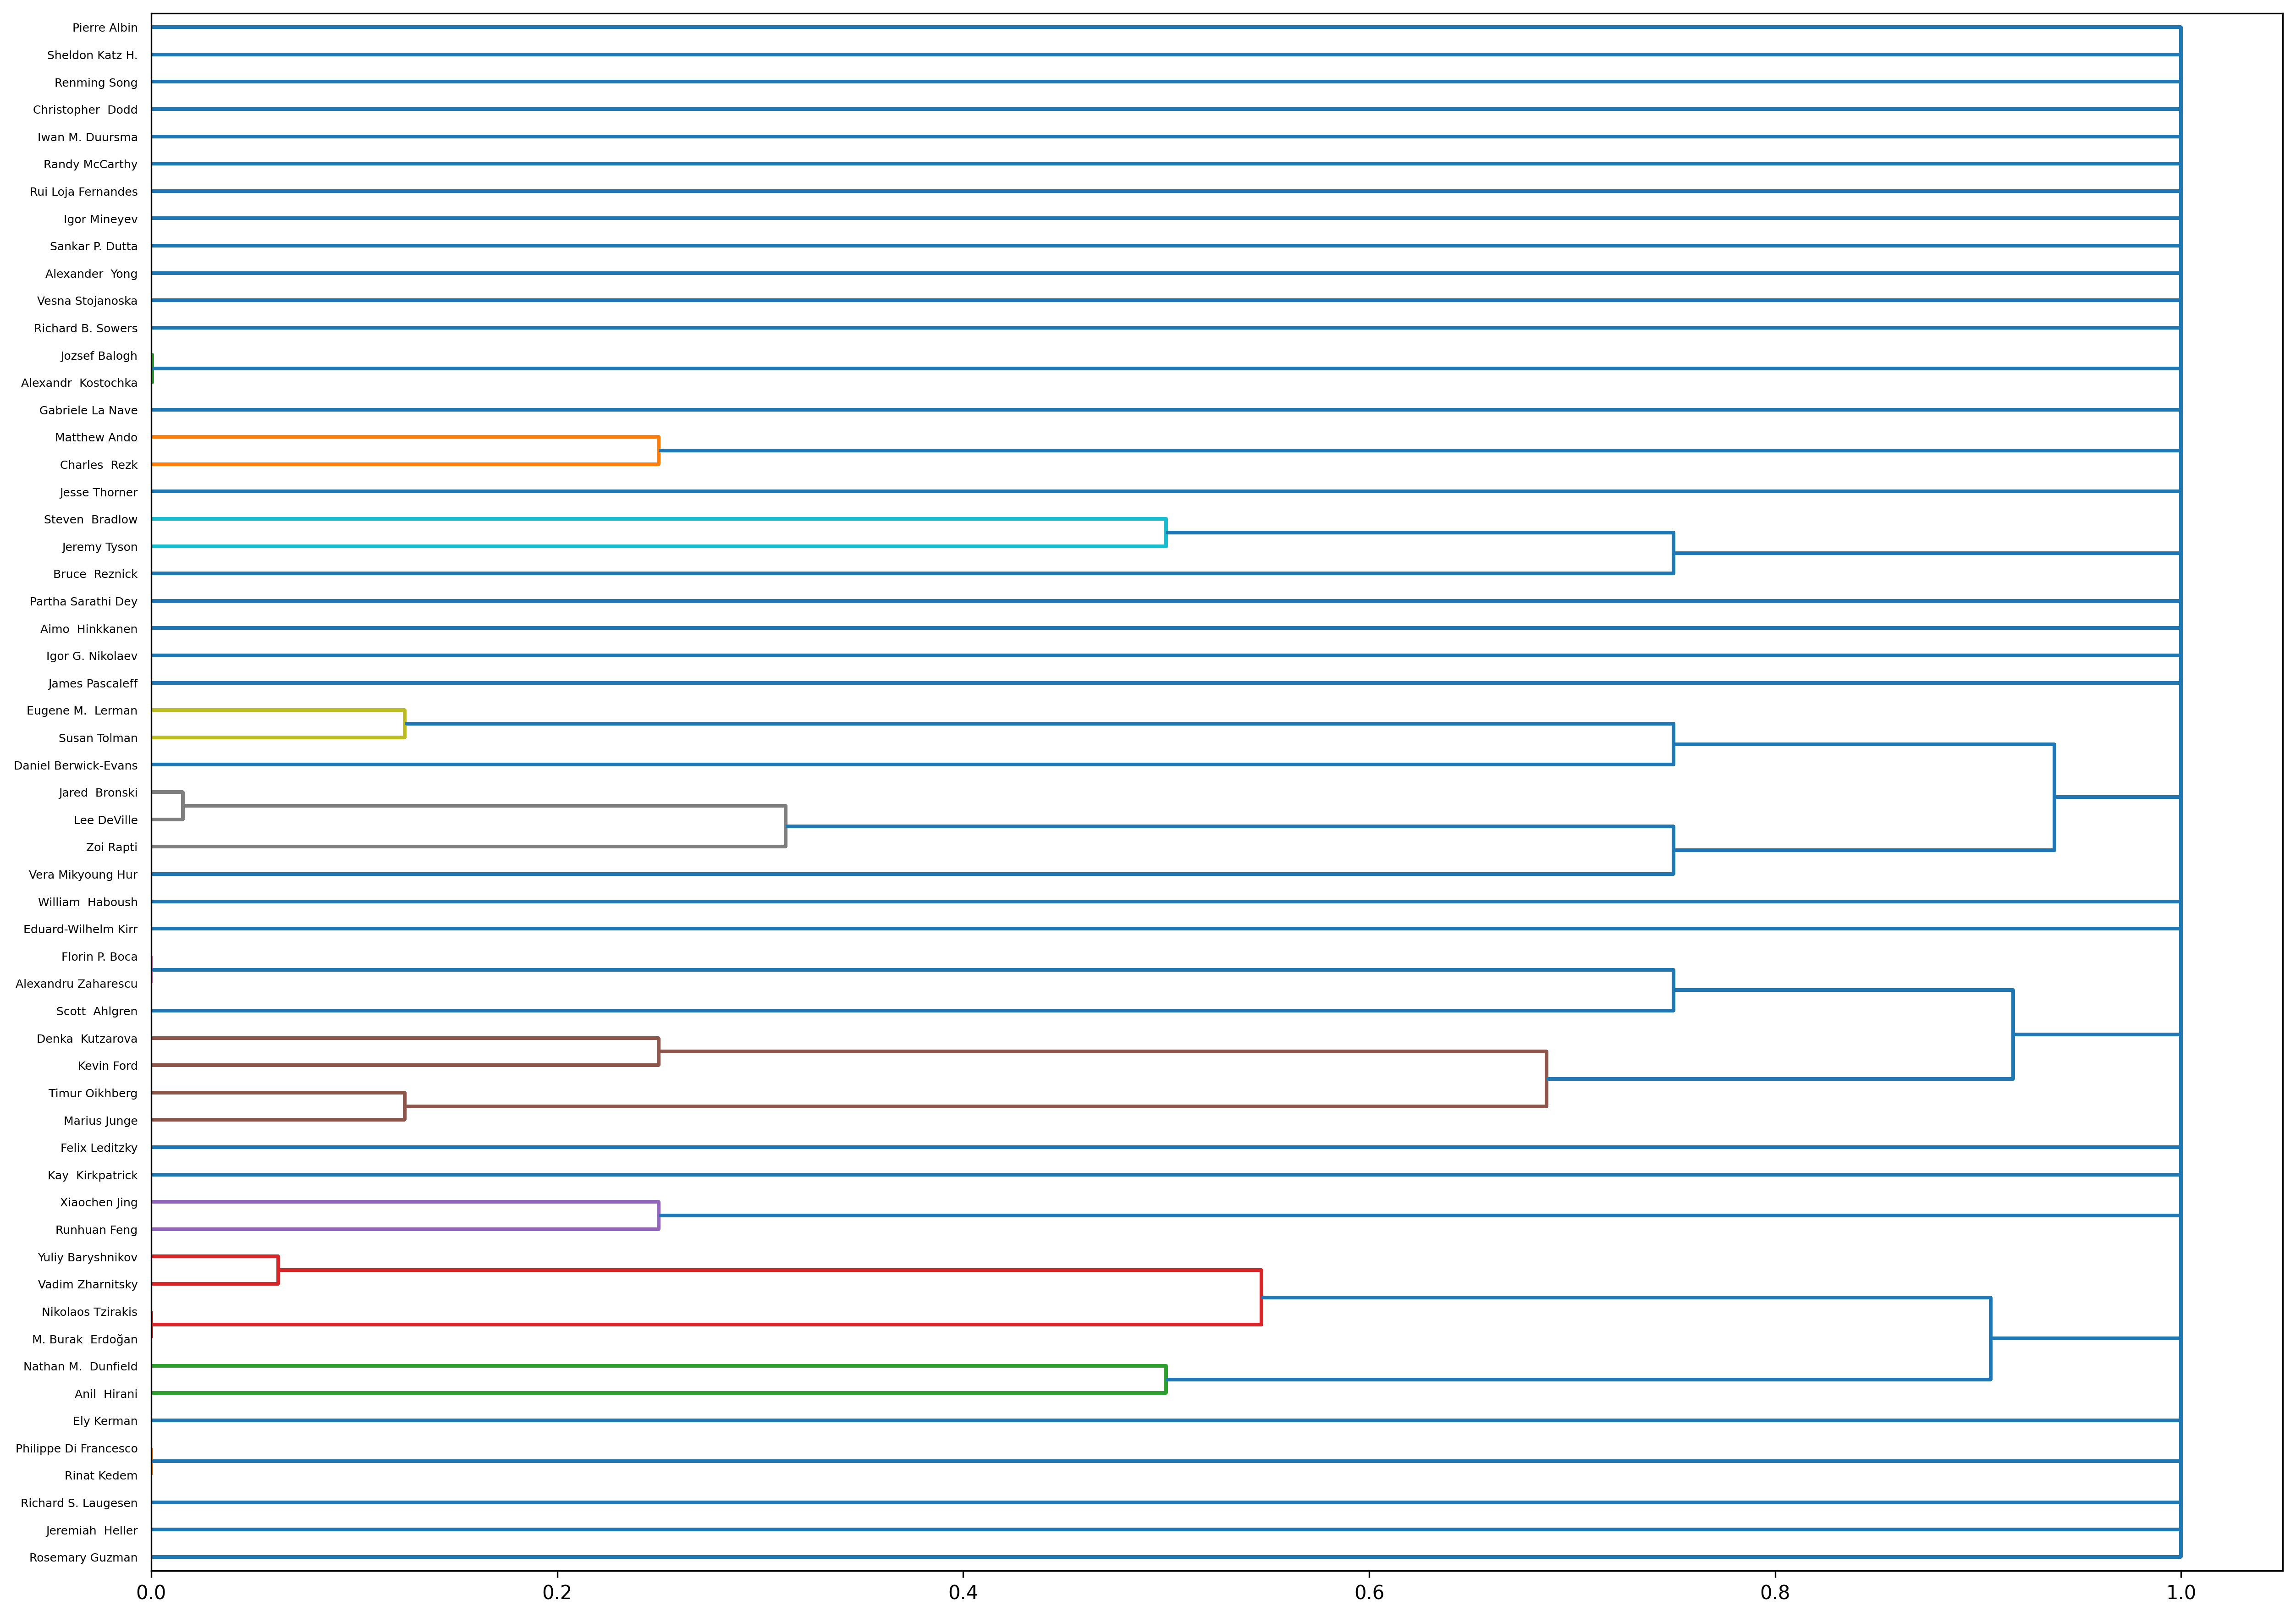

In [22]:
# Average
plot_dendrogram(dist_joint_pub, faculties, linkage="average")


# Clustering with # of shared citations

**Number of Shared Citations**

This data represents how many times each pair of faculties are cited in the same paper.

For example, if there are 10 papers that cited both faculty A and B, then entry (A,B) of this dataset would be 10.

***Potential limitation of clustering using citation data:***

The "Shared citations" of authors A and B are the number of papers that cited both A and B. As a result, this metric is affected by not only how closely A and B work together, but also the activity of their field of research.

For example, suppose A worked with B and published 5 papers in area X, while A also worked with C and published 5 papers in area Y. In this setting, we would expect that distance(A, B) is similar to distance(A, C). However, if area X is an area of high interest where lots of papers are published each year, while area Y is an area of relatively low interest, then we will likely see much more papers citing A and B than papers citing A and C. As a result, the metric based on "shared citations" would have distance(A, B) >> distance(A, C).

In [13]:
f_joint_cite = os.path.join(data_dir, "citation_joint.json")
with open(f_joint_cite) as file:
    d_joint_cite = ujson.load(file)

In [14]:
# Construct similarity matrix and distance matrix
num_ppl = len(faculties)
sim_joint_cite = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_cite.items():
    sim_joint_cite[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_cite += sim_joint_cite.T

## Dendrograms

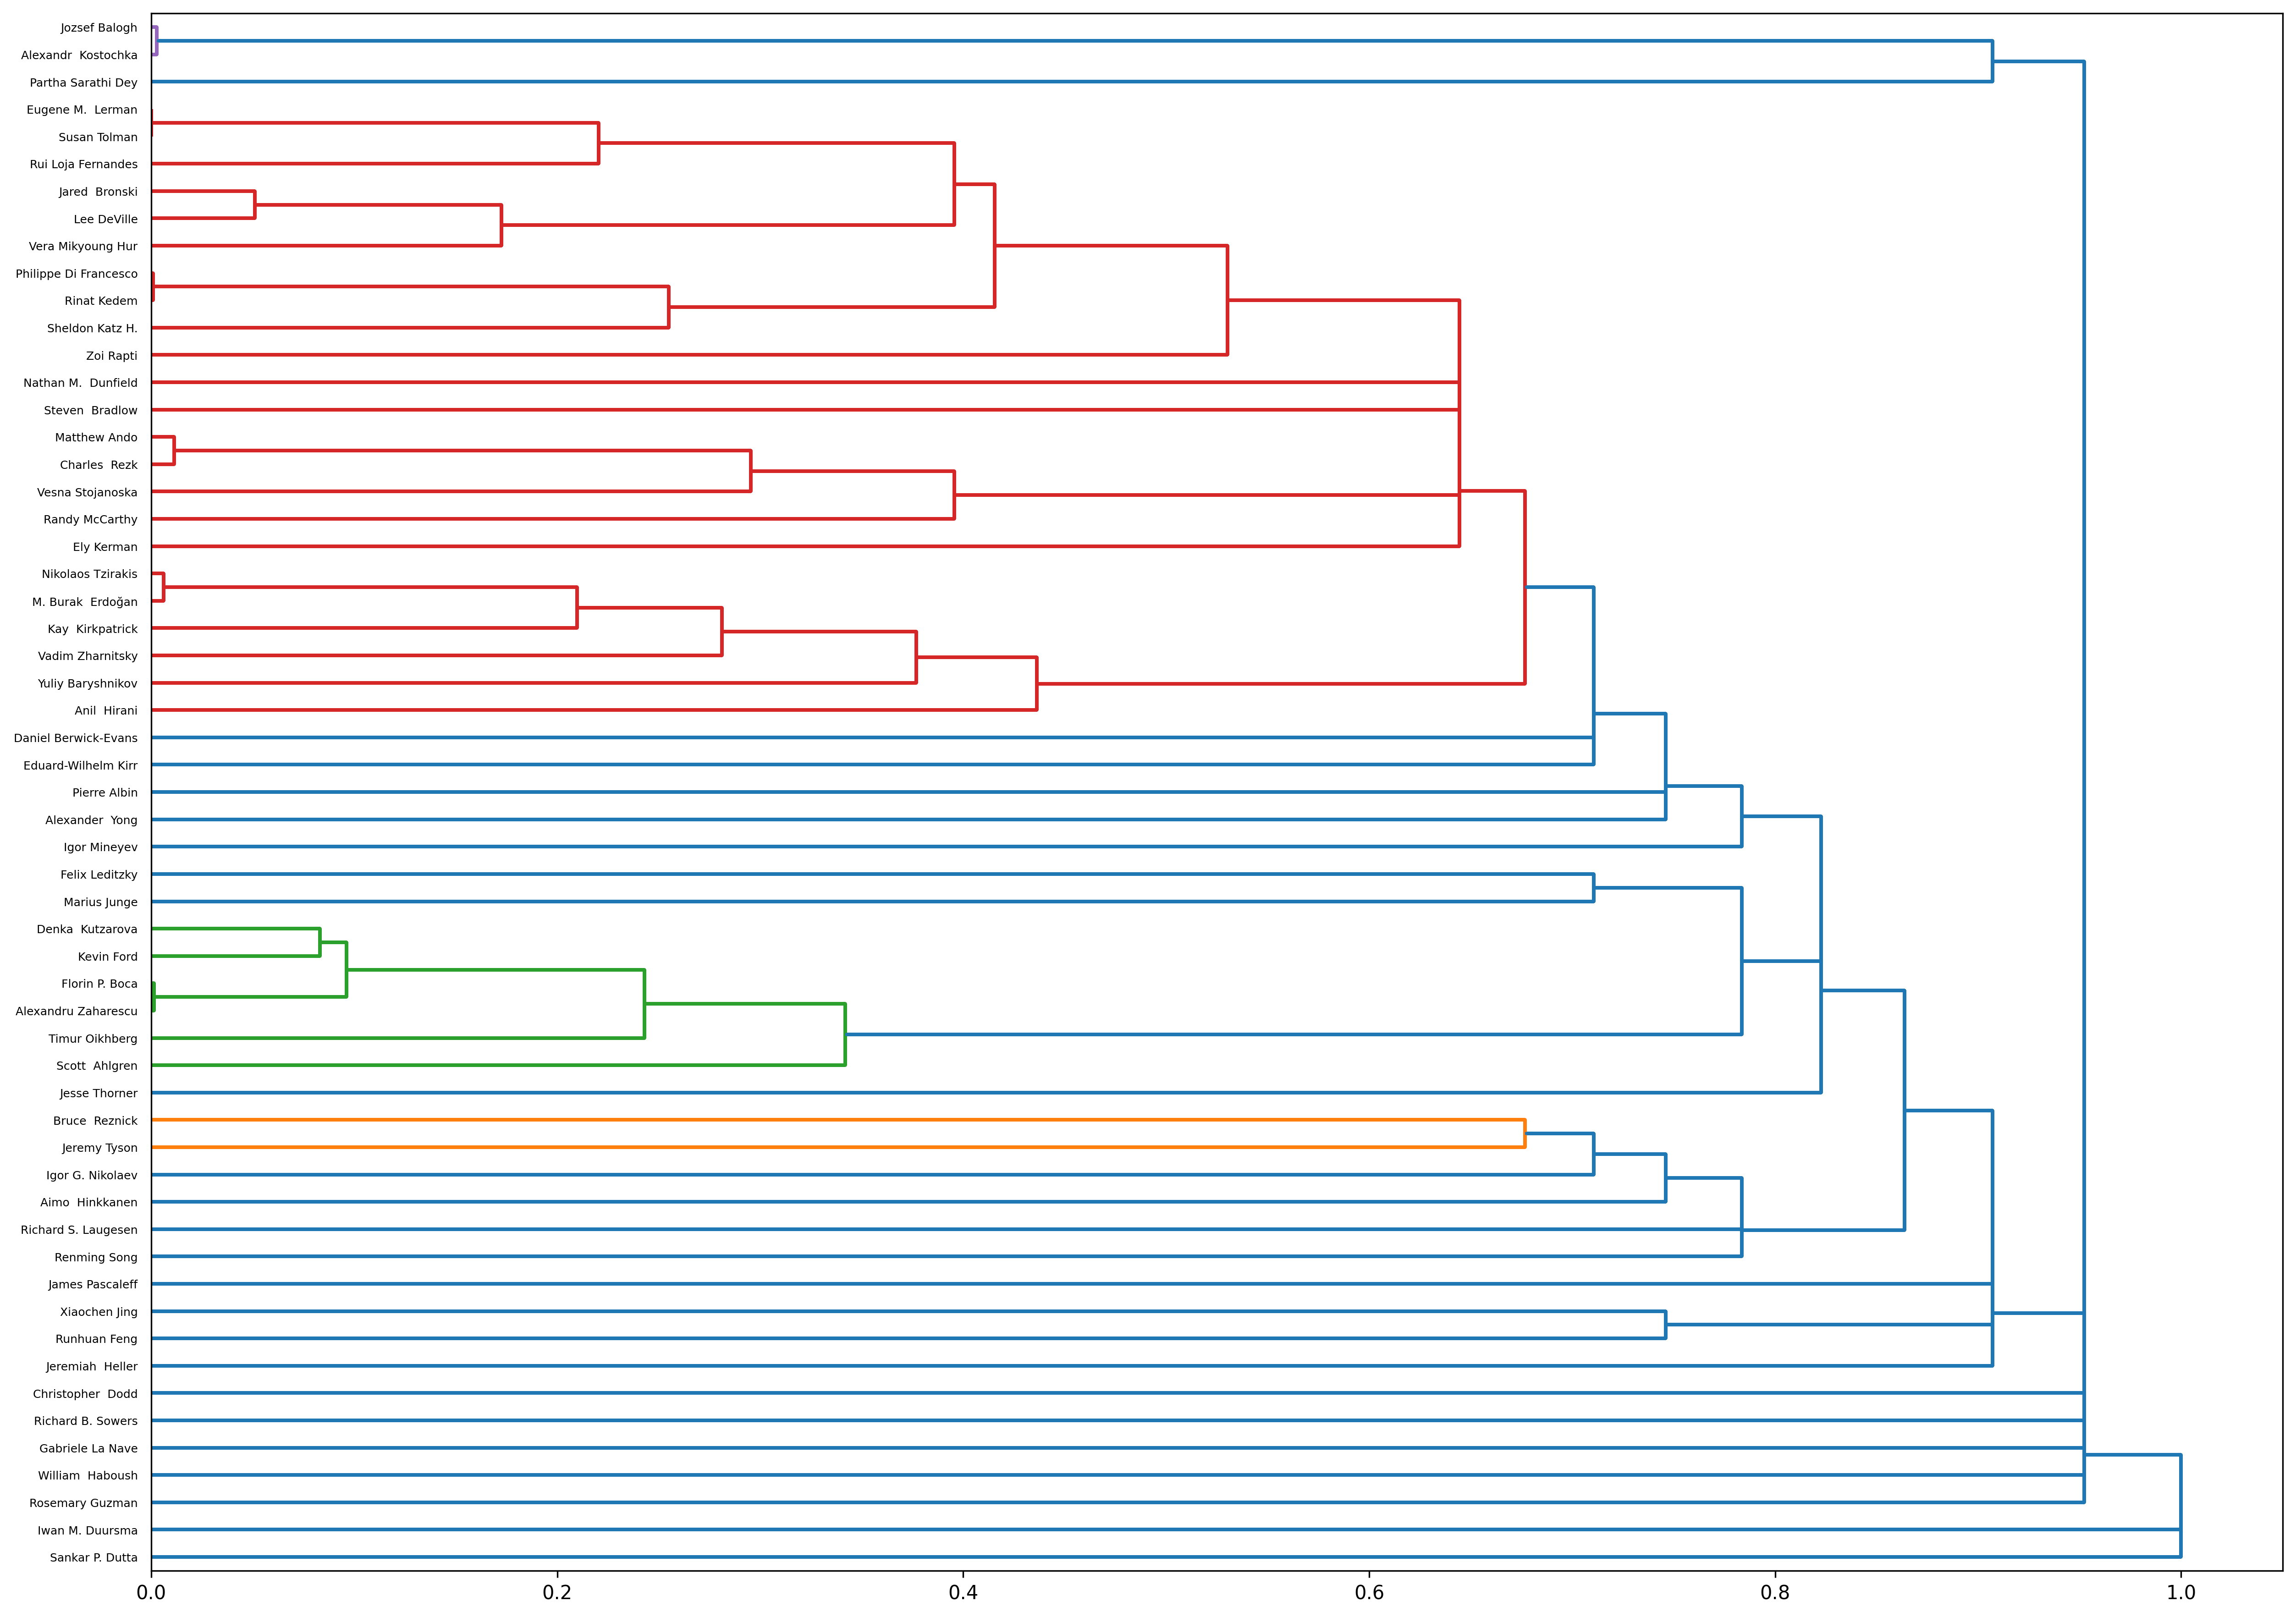

In [24]:
plot_dendrogram(d1(sim_joint_cite, 1.05), faculties, linkage="single")

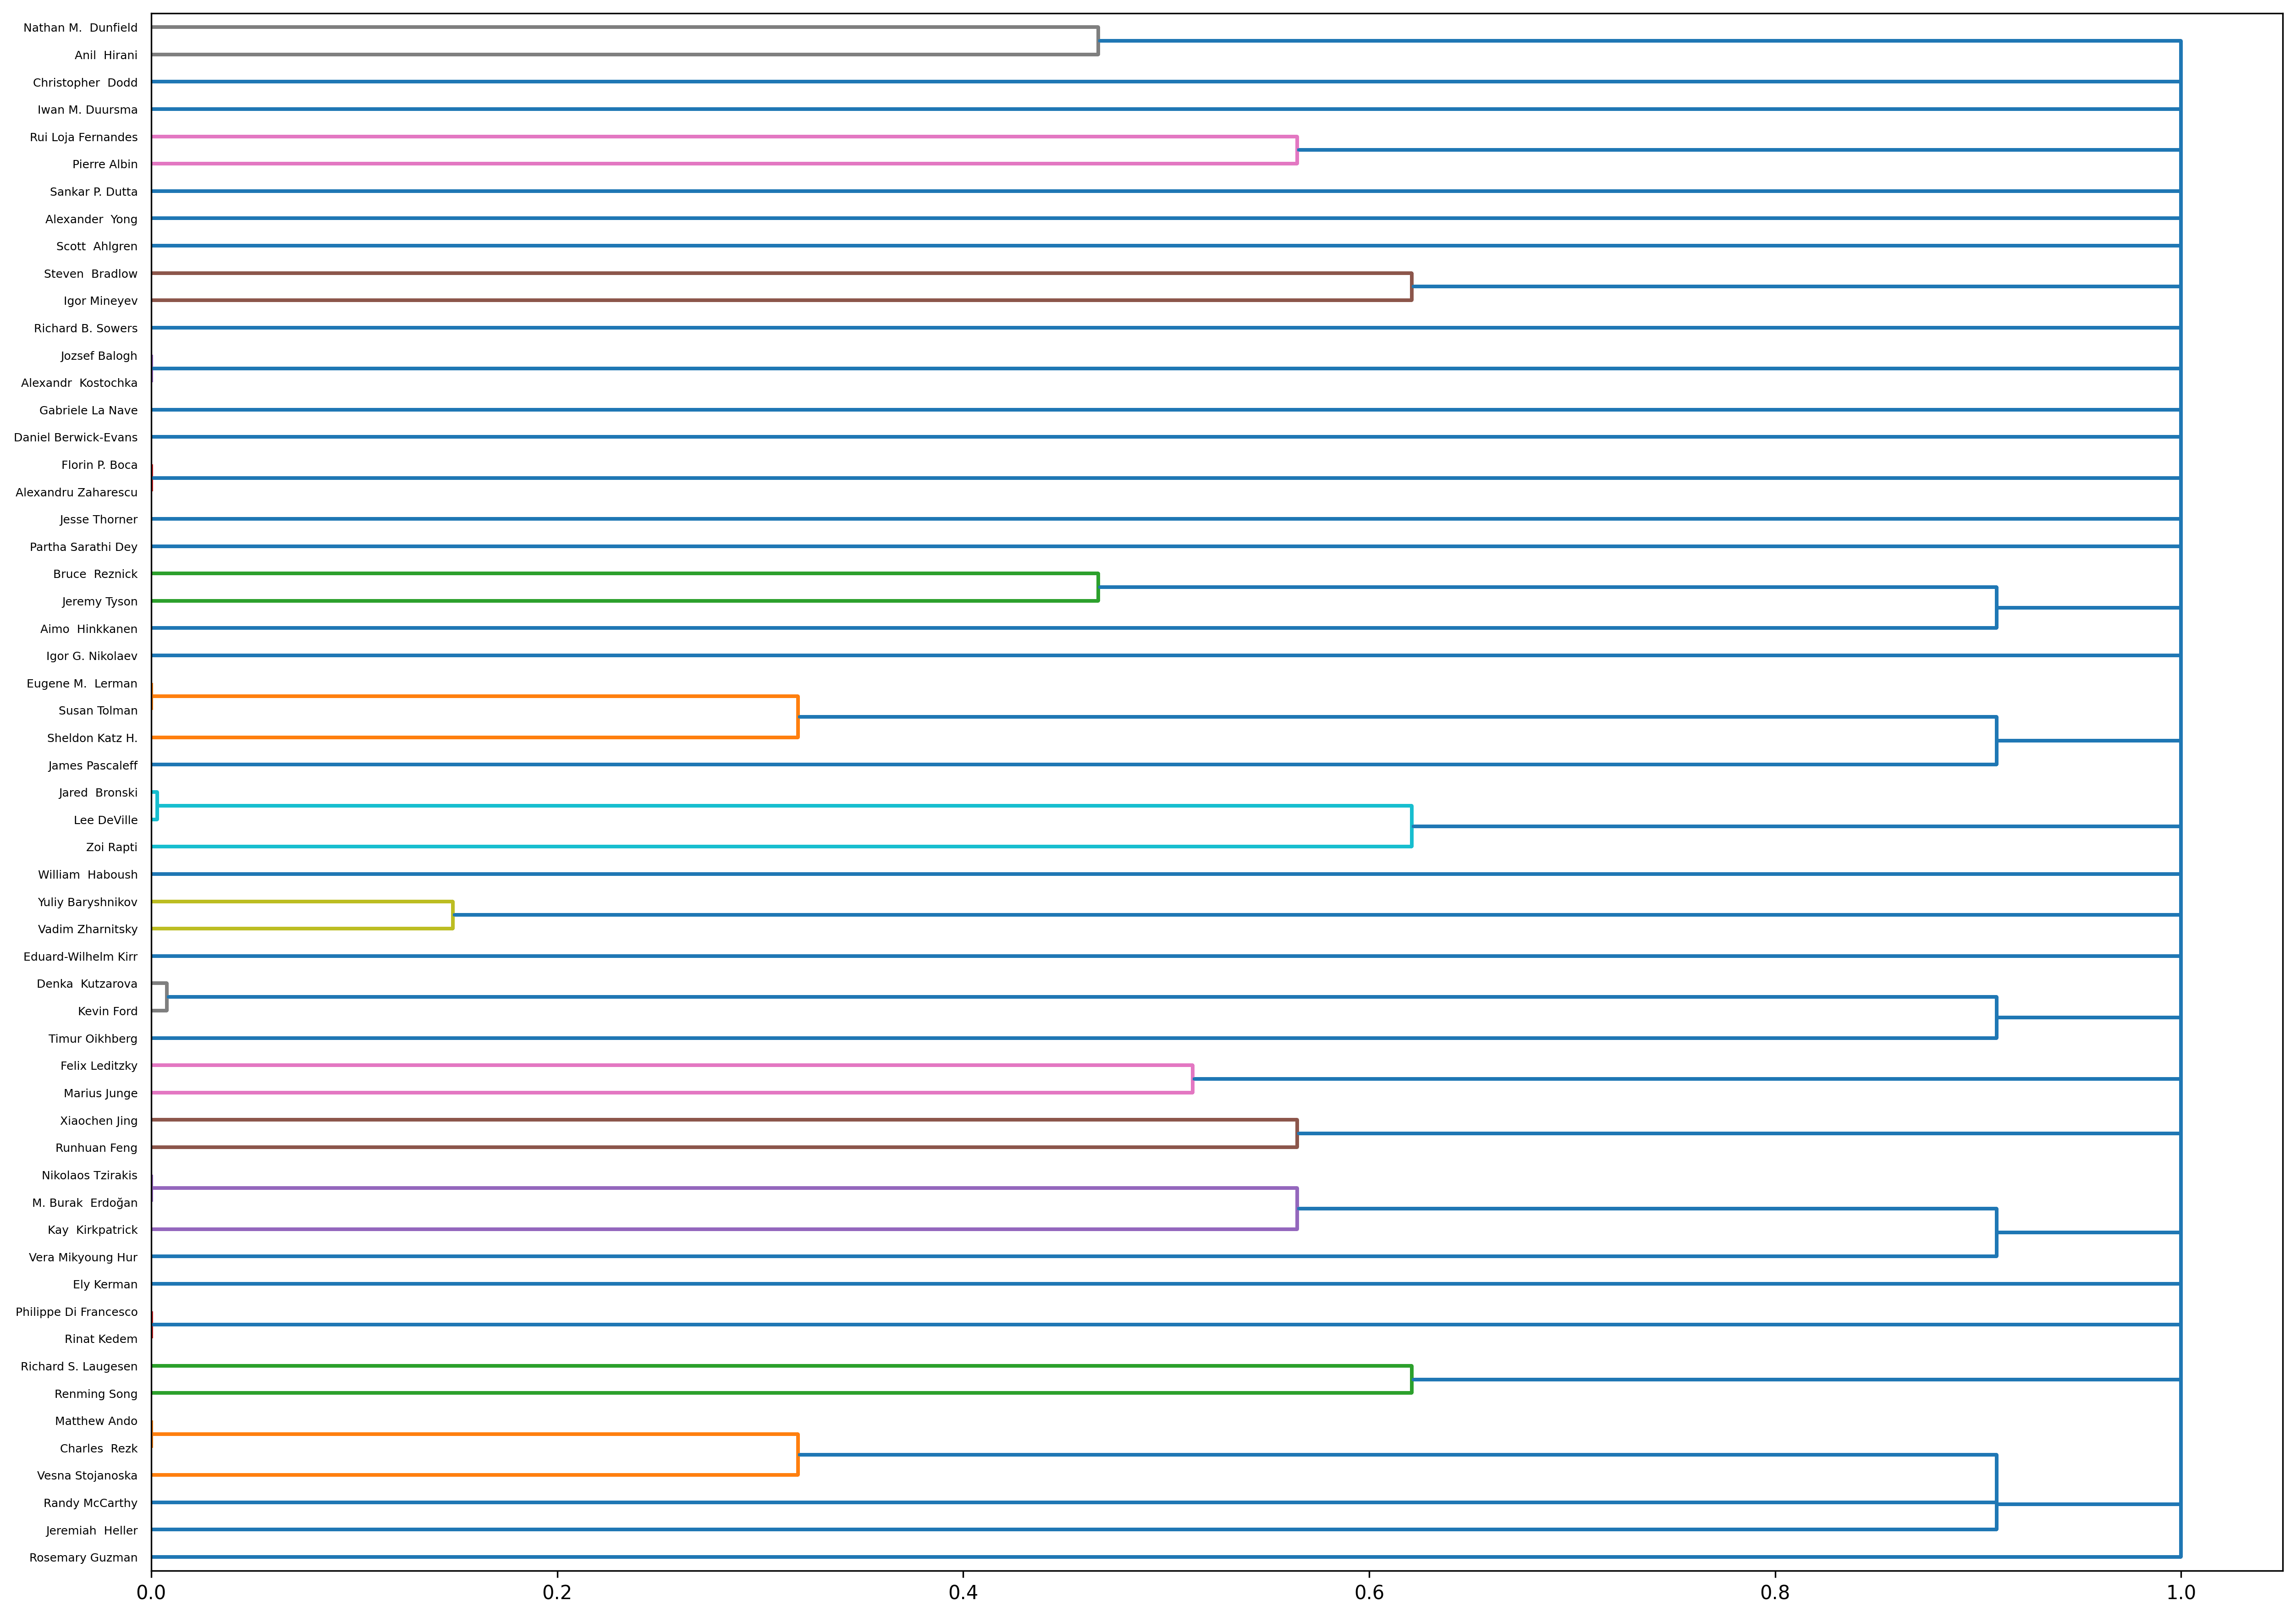

In [25]:
plot_dendrogram(d1(sim_joint_cite, 1.1), faculties, linkage="complete")

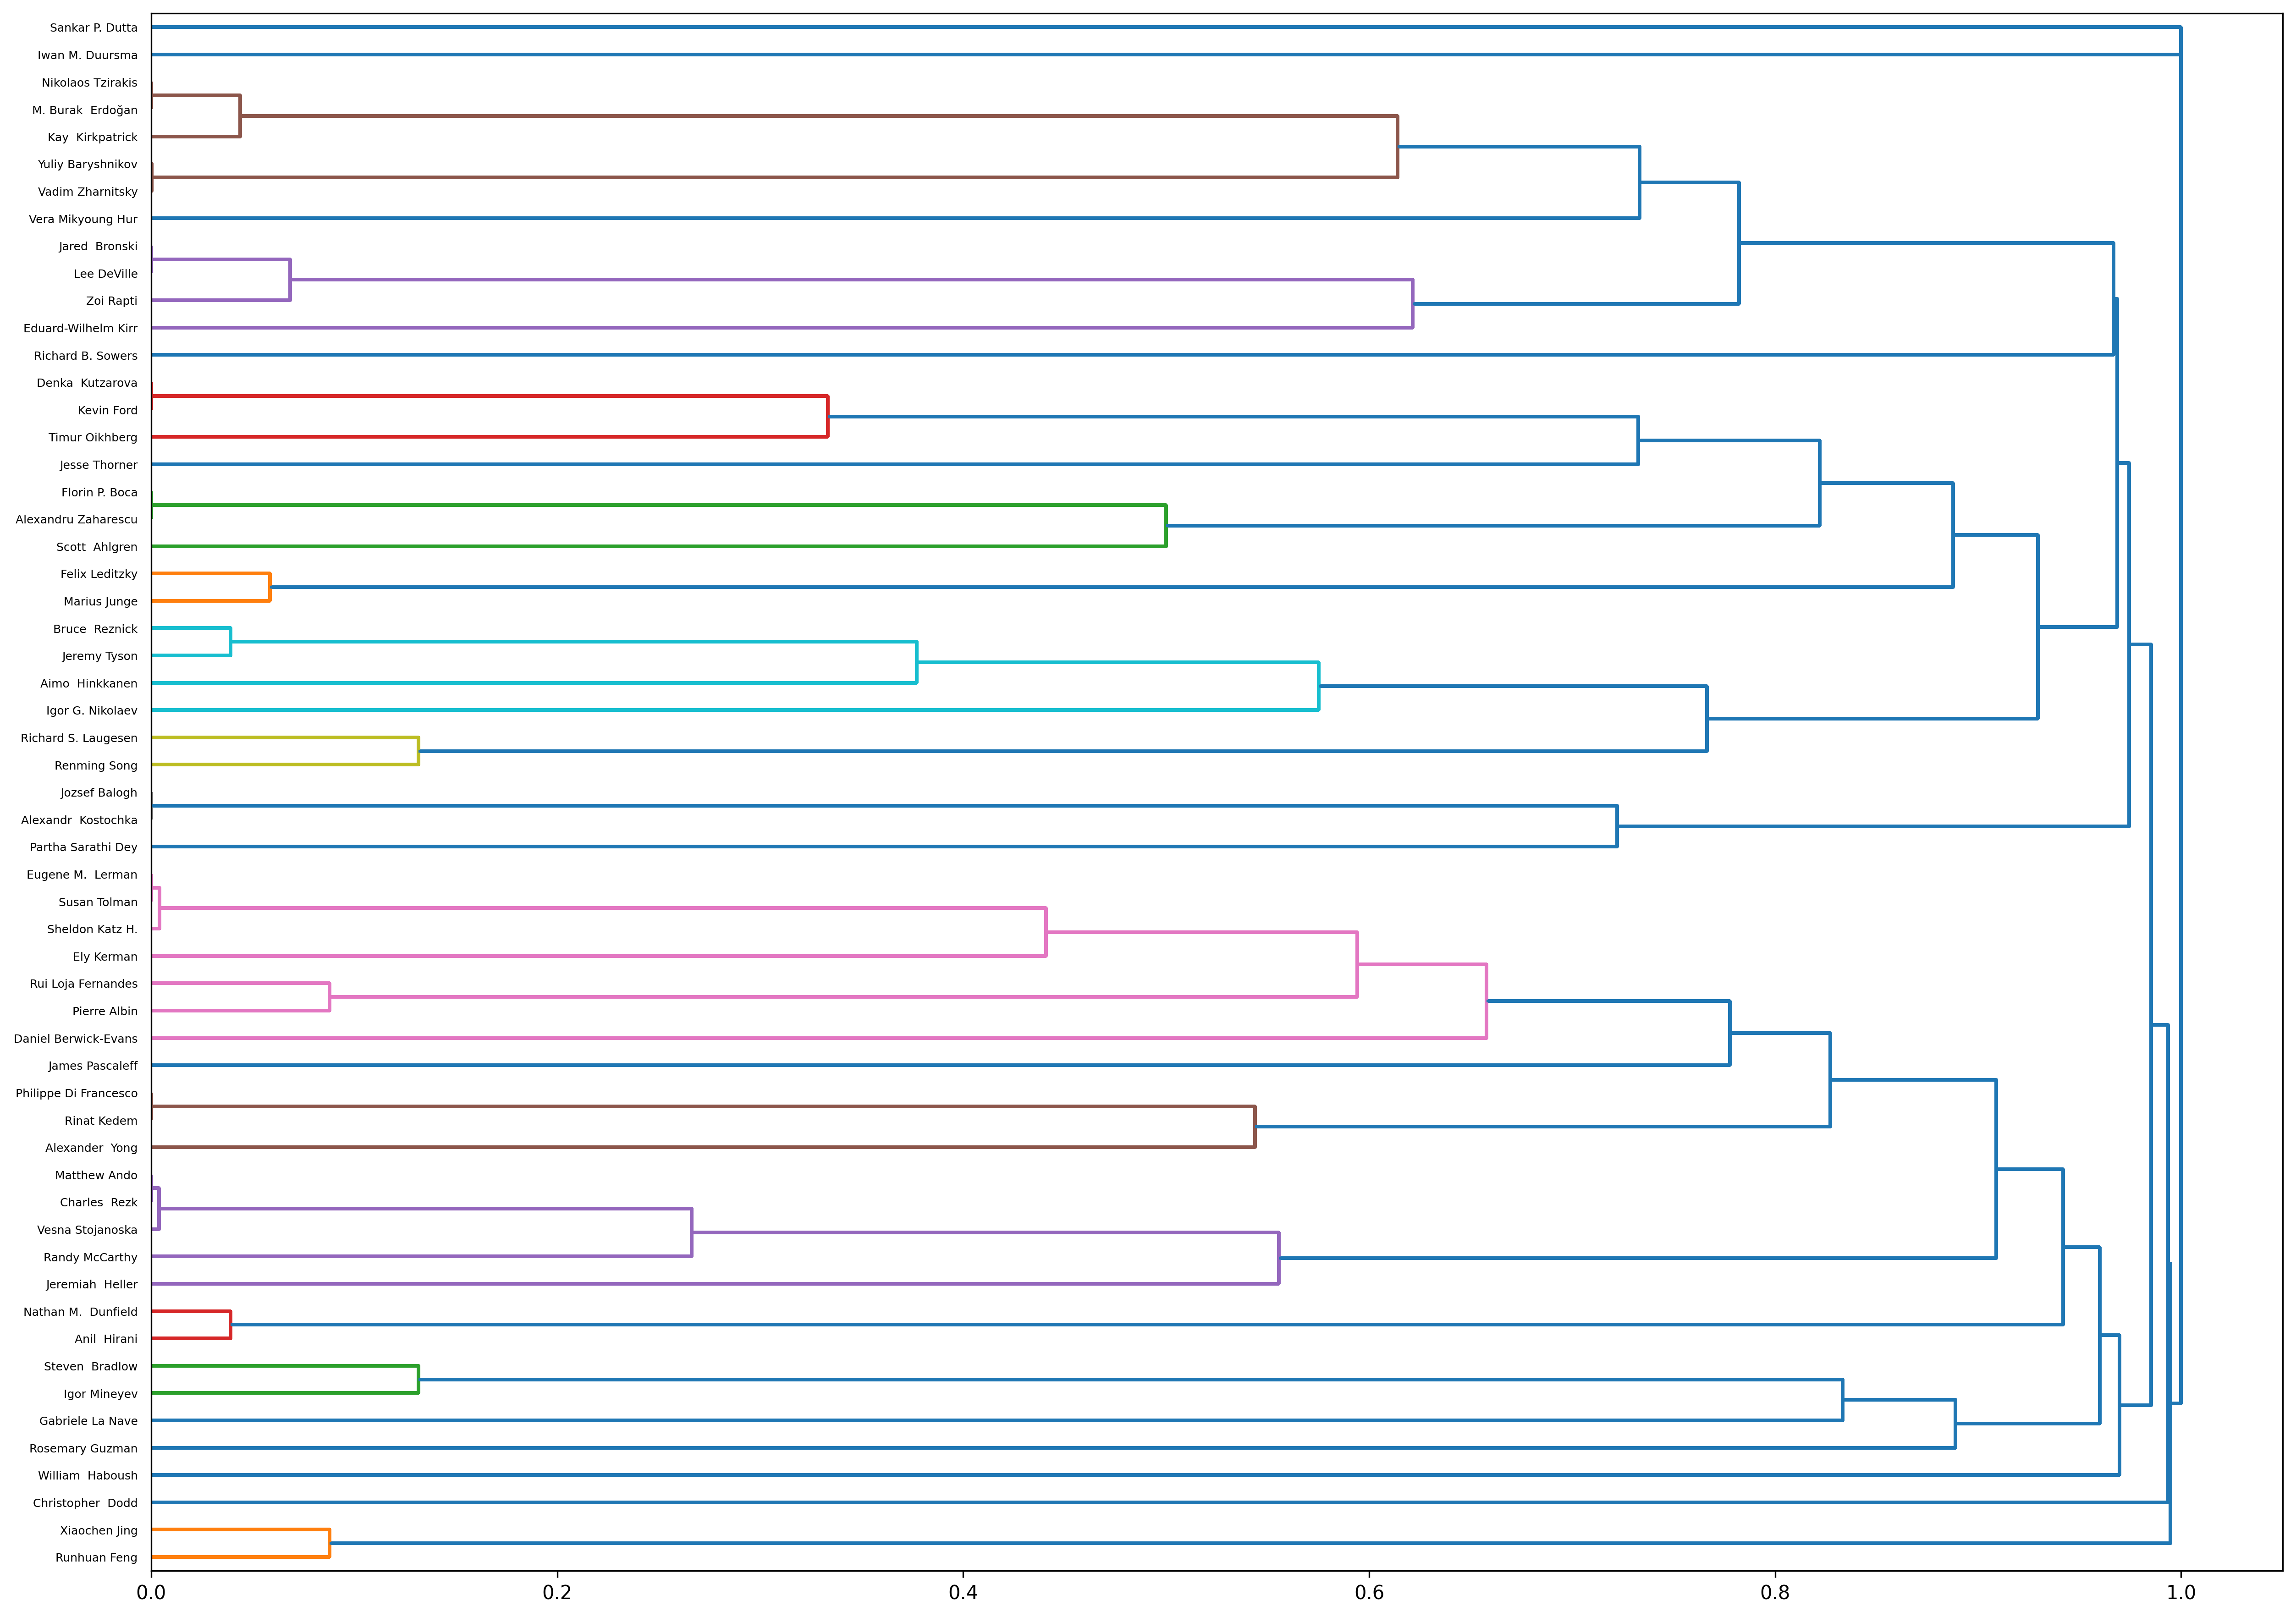

In [15]:
plot_dendrogram(d1(sim_joint_cite, 1.5), faculties, linkage="average")

# Clustering with # of directed citations

**Number of Directed Citations**

This data represents how many times one faculty cited another faculty in all his/her publications.

For example, if A cited B 10 times in all of A's publications, then the entry (A, B) would be 10.

***Limitation of Clustering using Number of Directed Citations***

By the nature of this data, if A and B work very closely such that they co-authored every paper they published, then obviously they won't have any direct citation to each other. In this case, the distance of A and B based on this dataset would be very large, which doesn't reflect reality.

We may want to add this dataset with the joint publication dataset to compensate for aforementioned problem.

In [19]:
f_dir_cite = os.path.join(data_dir, "citation_directed.json")
with open(f_dir_cite) as file:
    d_dir_cite = ujson.load(file)
    pass

In [20]:
# Construct similarity matrix and distance matrix
num_ppl = len(faculties)

i = 0
j = 0

sim_dir_cite = np.zeros((num_ppl, num_ppl))

for key, val in d_dir_cite.items():
    sim_dir_cite[i, j] = val
    
    j += 1
    if j == num_ppl:
        i += 1
        j = 0
        pass
    pass

sim_dir_cite += sim_dir_cite.T

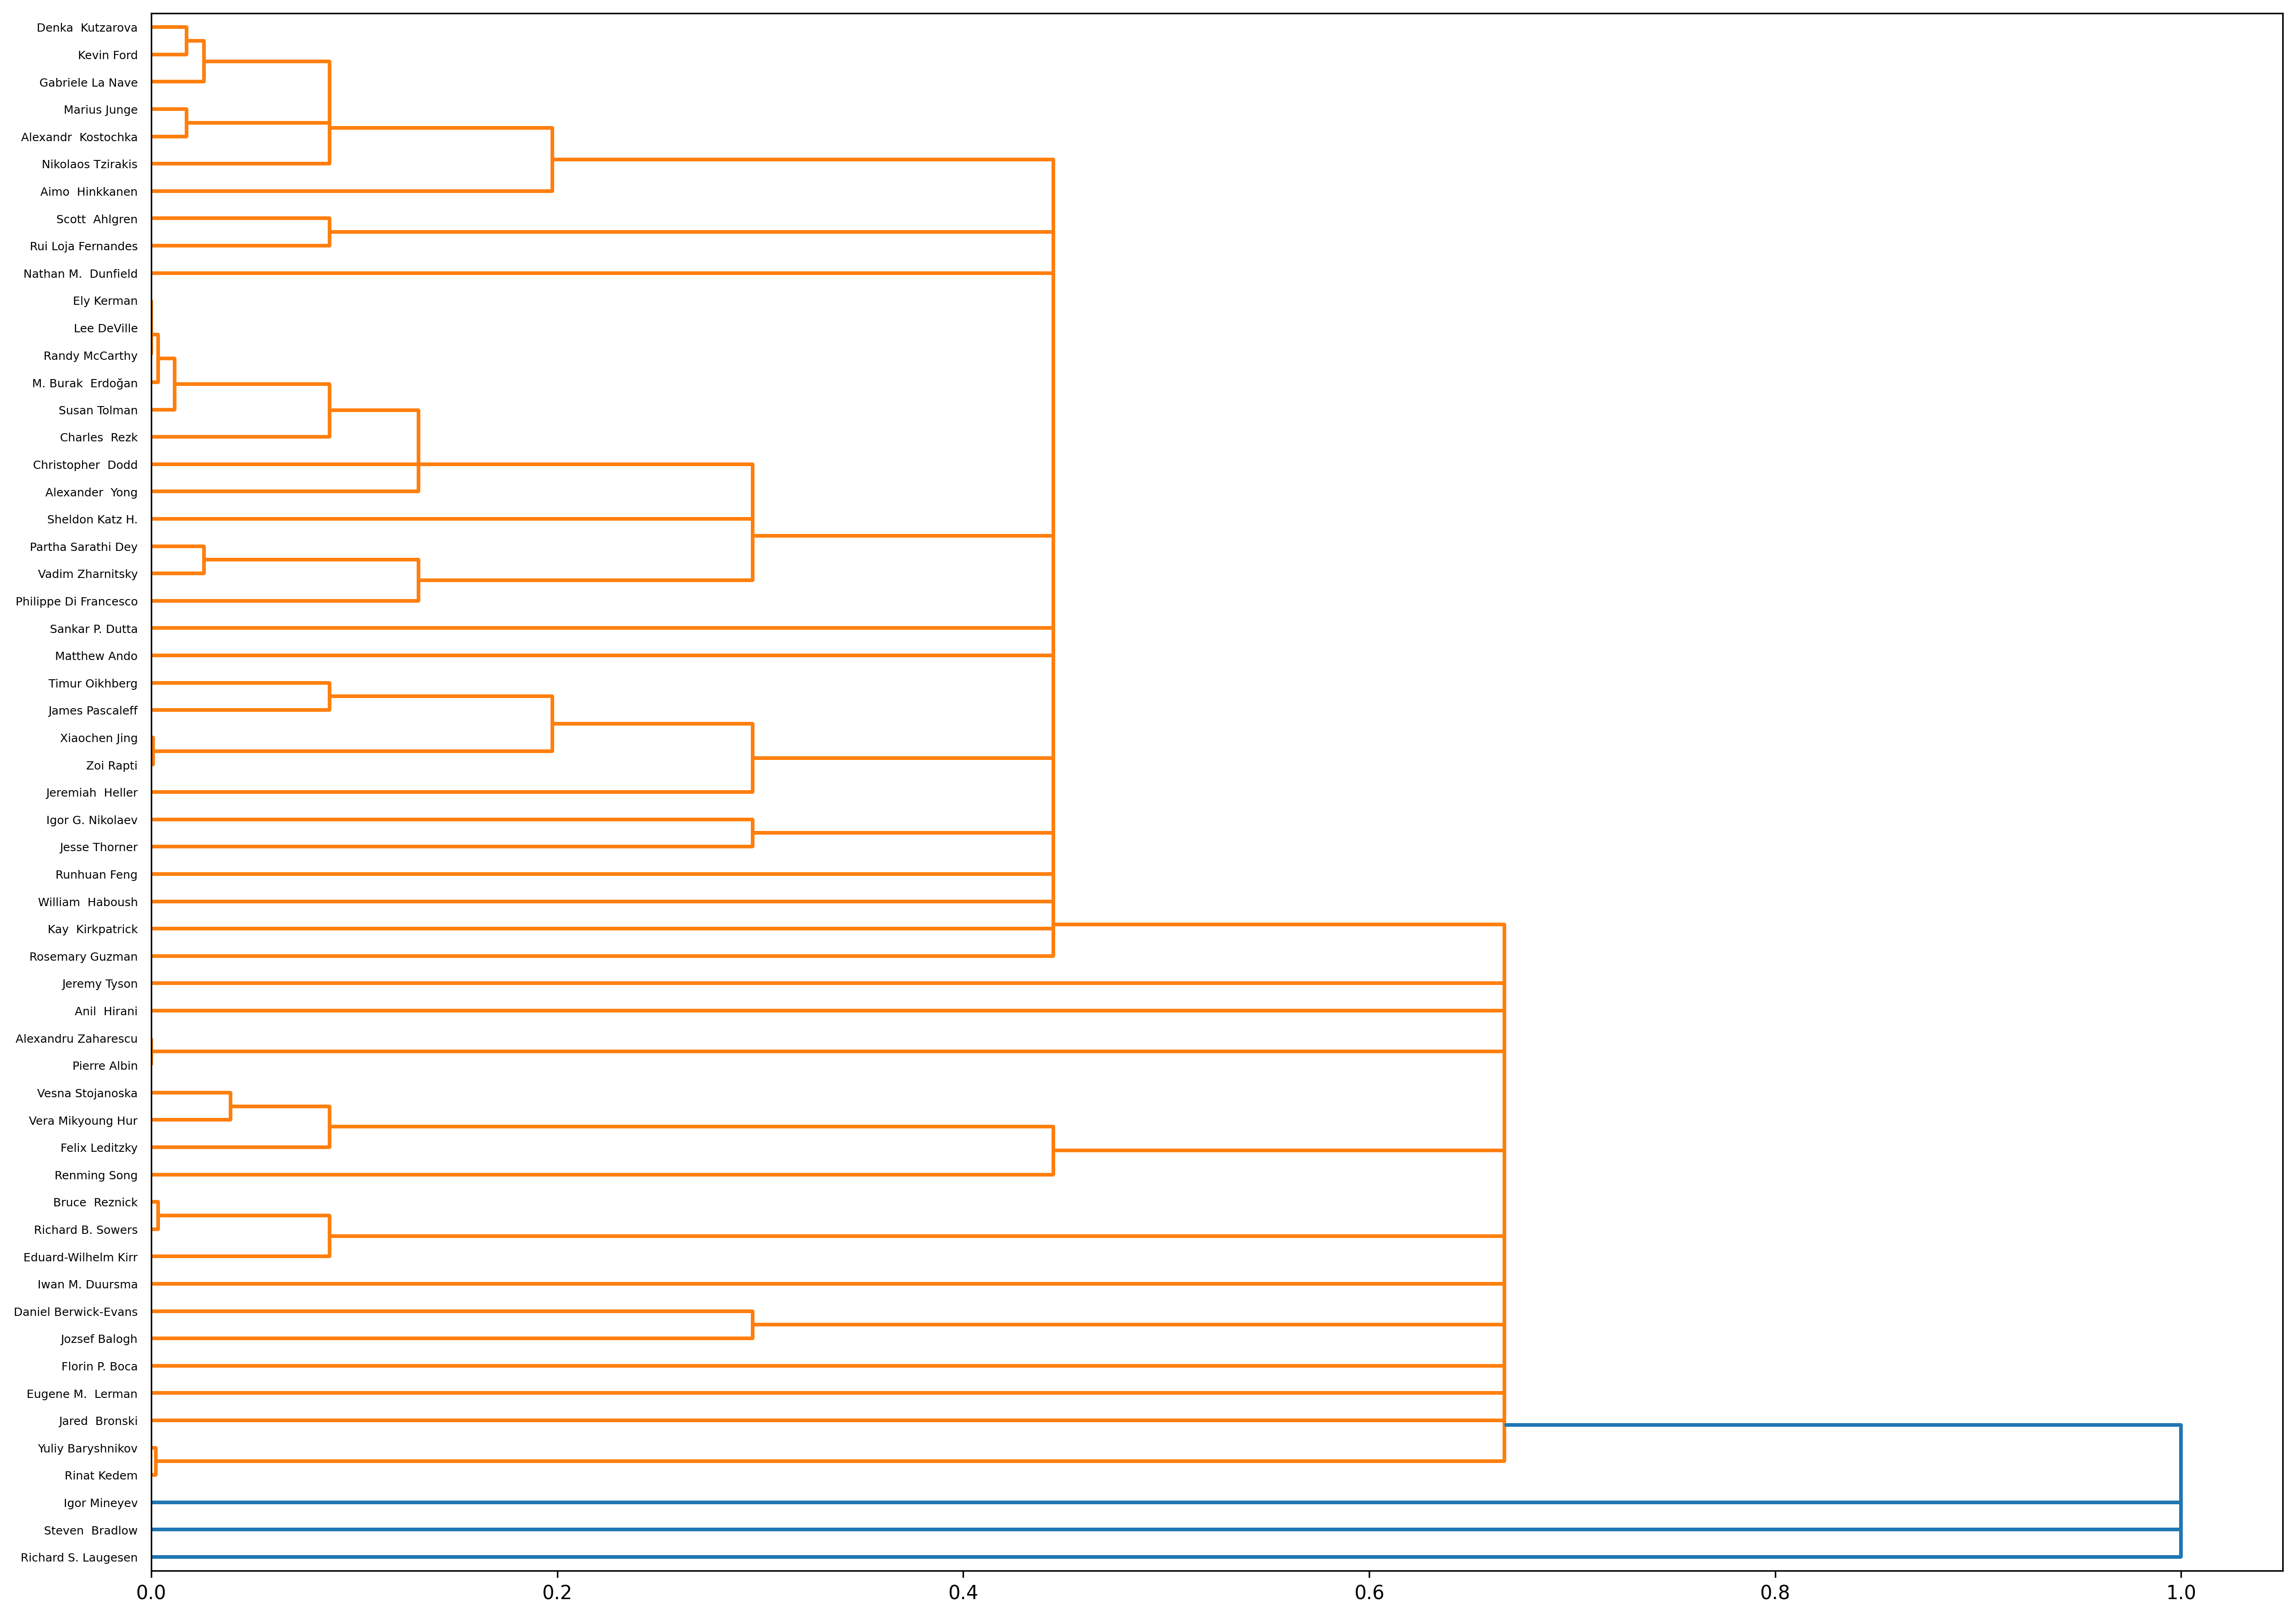

In [21]:
plot_dendrogram(d1(sim_dir_cite, 1.5), faculties, linkage="single")

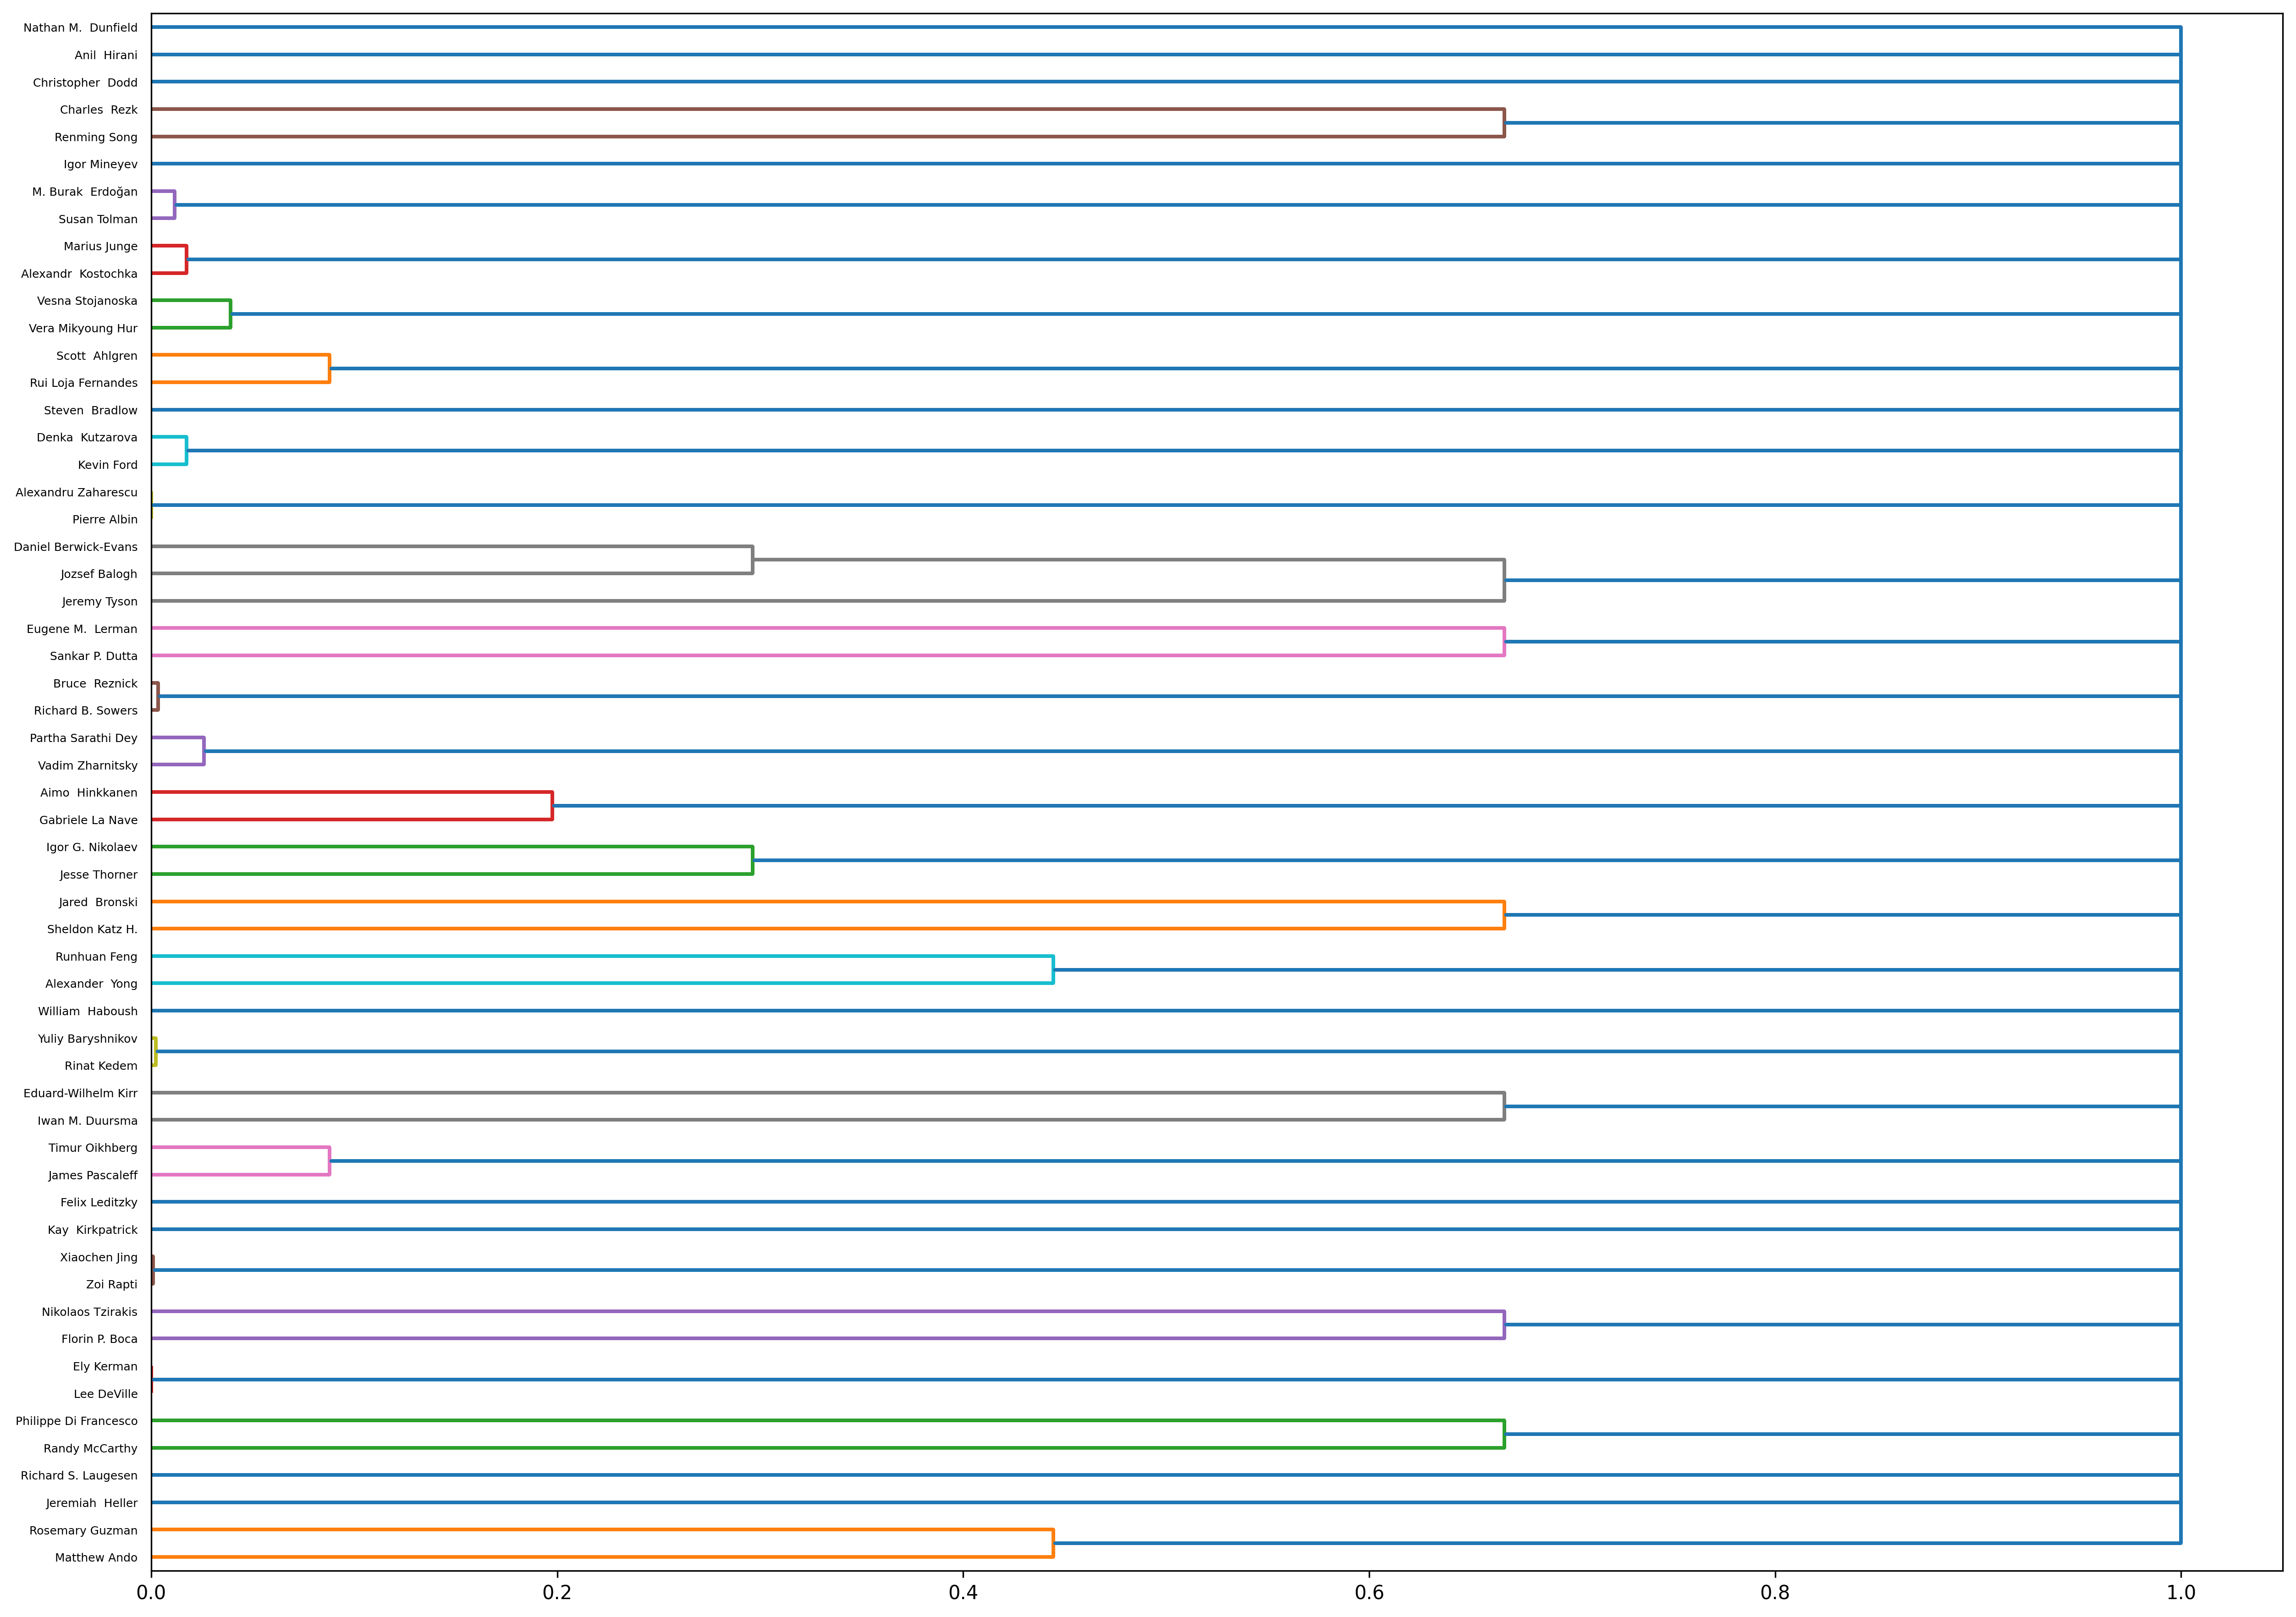

In [69]:
plot_dendrogram(d1(sim_dir_cite, 1.5), faculties, linkage="complete")

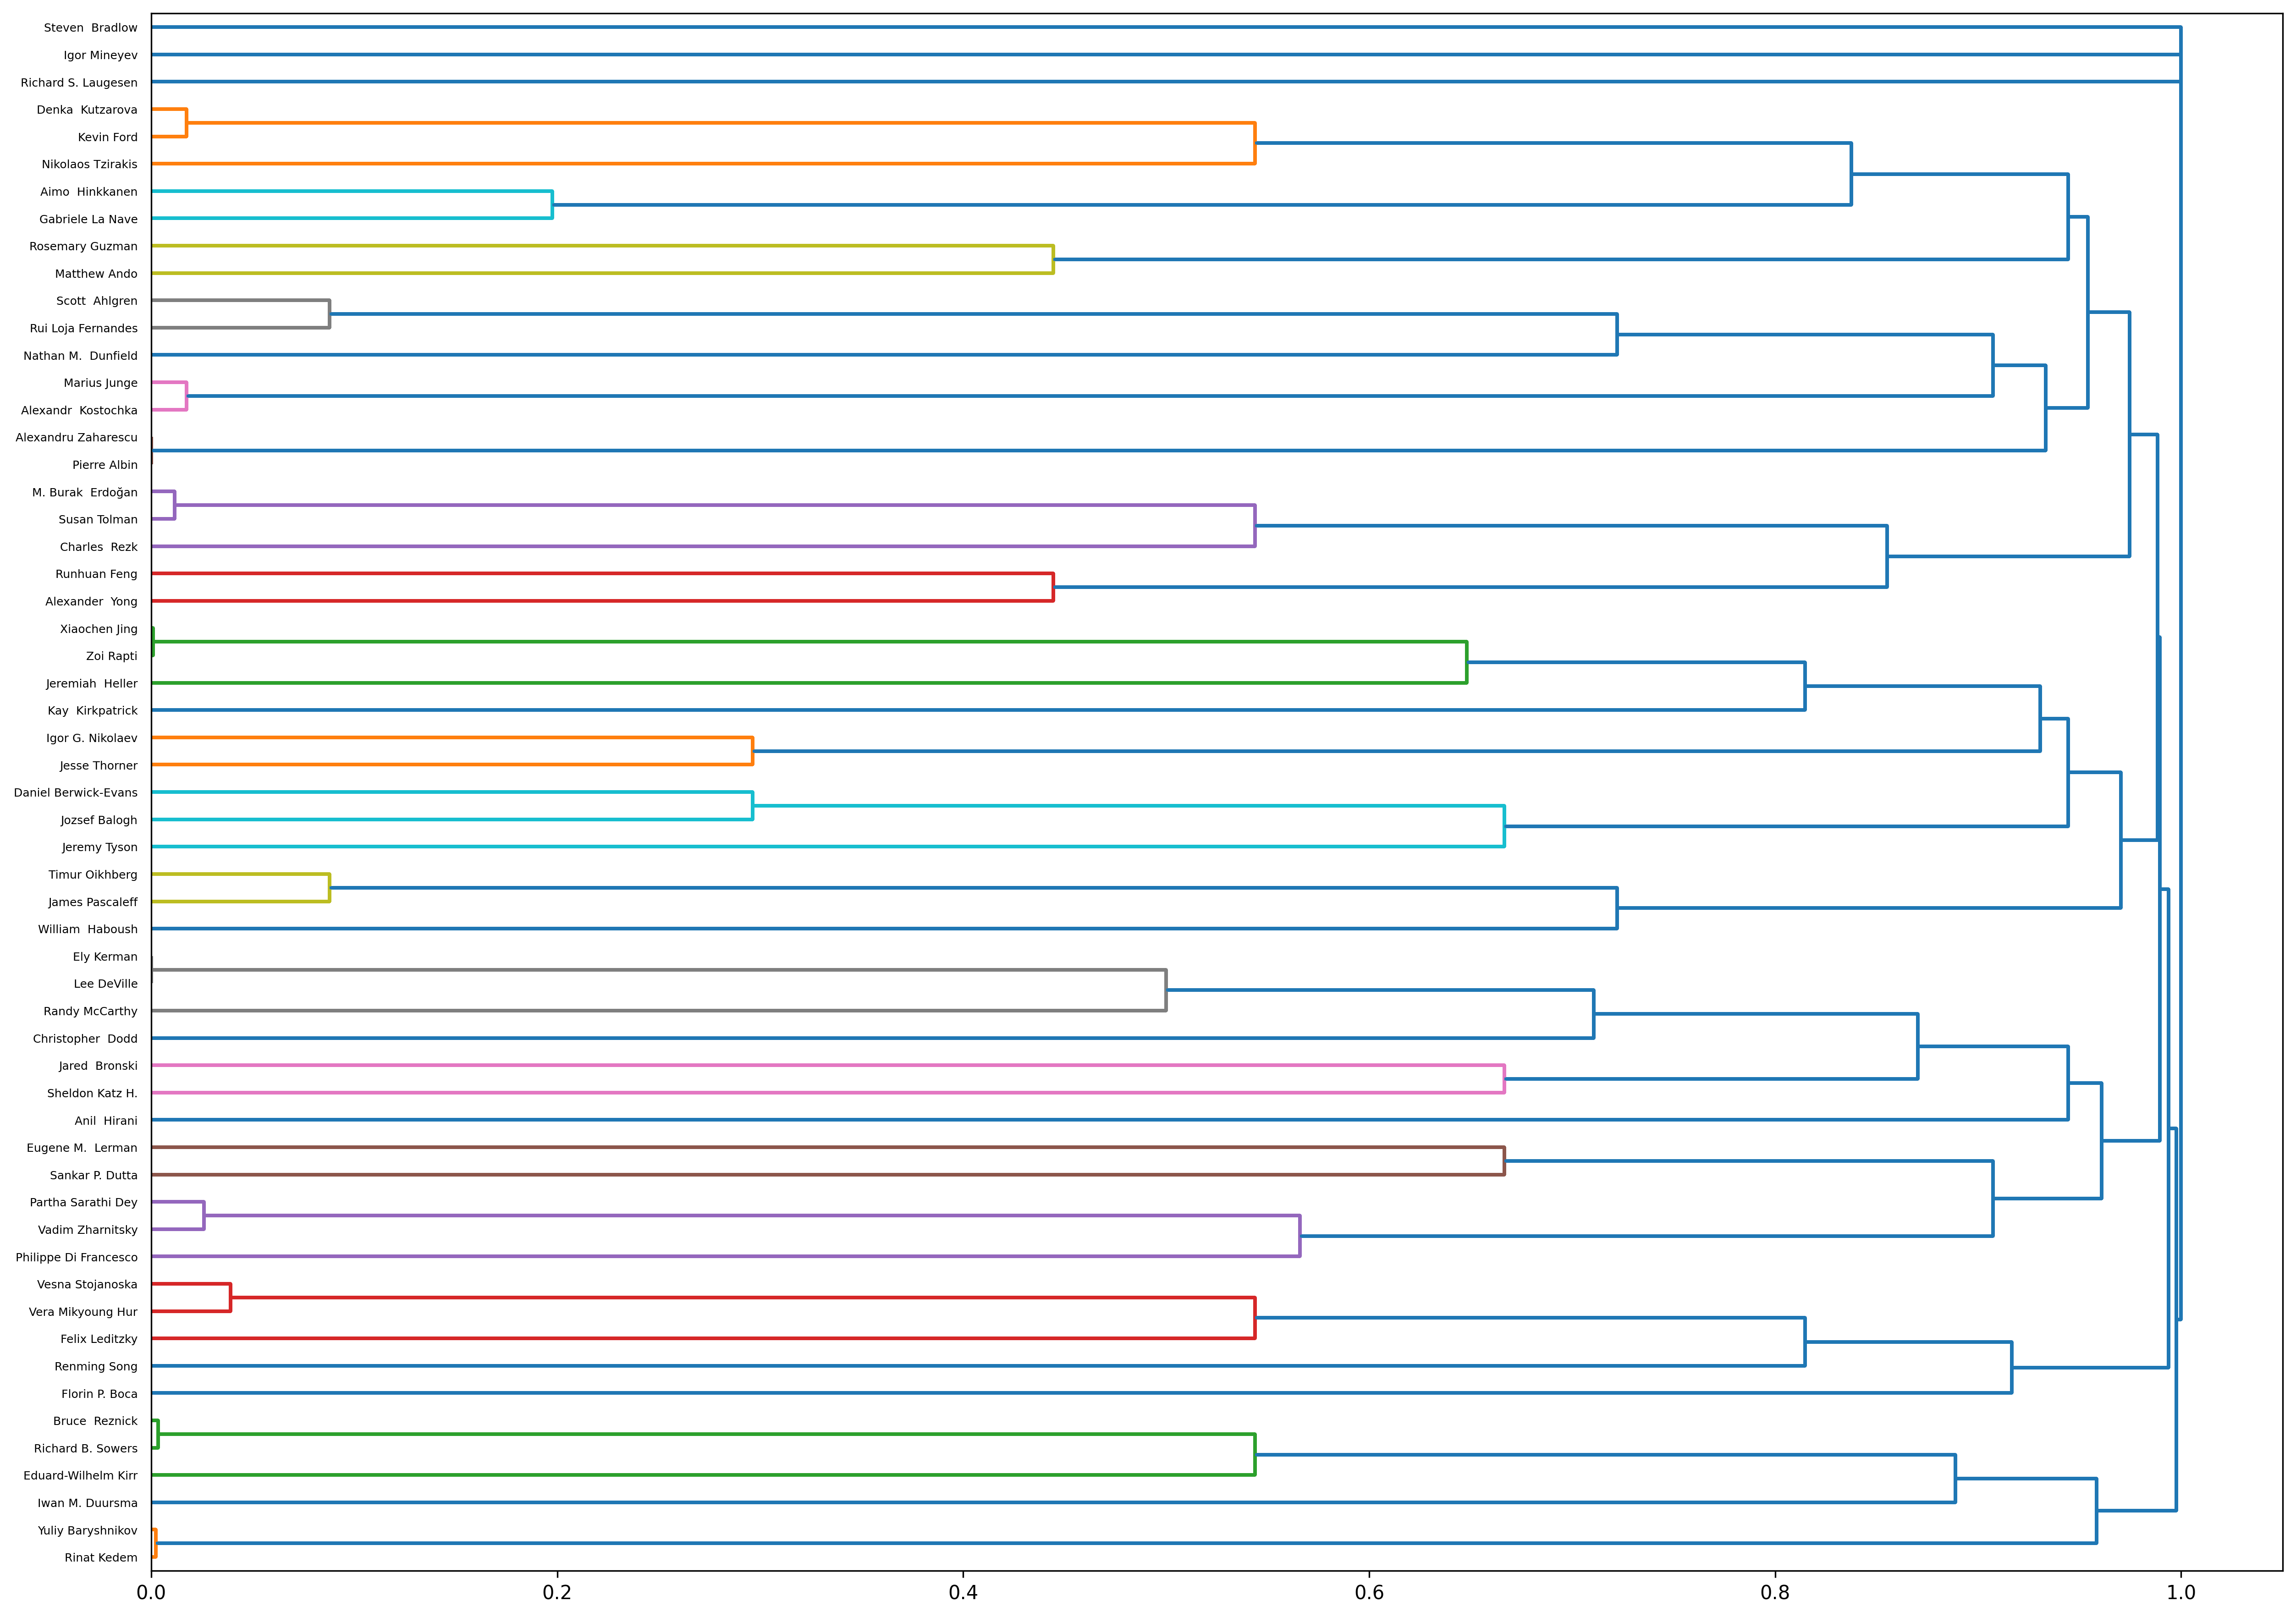

In [70]:
plot_dendrogram(d1(sim_dir_cite, 1.5), faculties, linkage="average")

# Clustering with # of joint publication + # of directed citations

As mentioned in the last section "Clustering with # of directed citations", we have reason to combine number of joint publication with # of directed citation to produce a more holistic dataset.

In addition, we may want to give different weights to the number of joint publication and number of directed citation. I.e. two people who co-authored a paper probably work much closer than two people who cited each other once.

In [22]:
weight_pub = 2
weight_cite = 1

weight_pub /= weight_pub + weight_cite
weight_cite /= weight_pub + weight_cite

sim_pub_cite = weight_pub * sim_joint_pub + weight_cite * sim_dir_cite

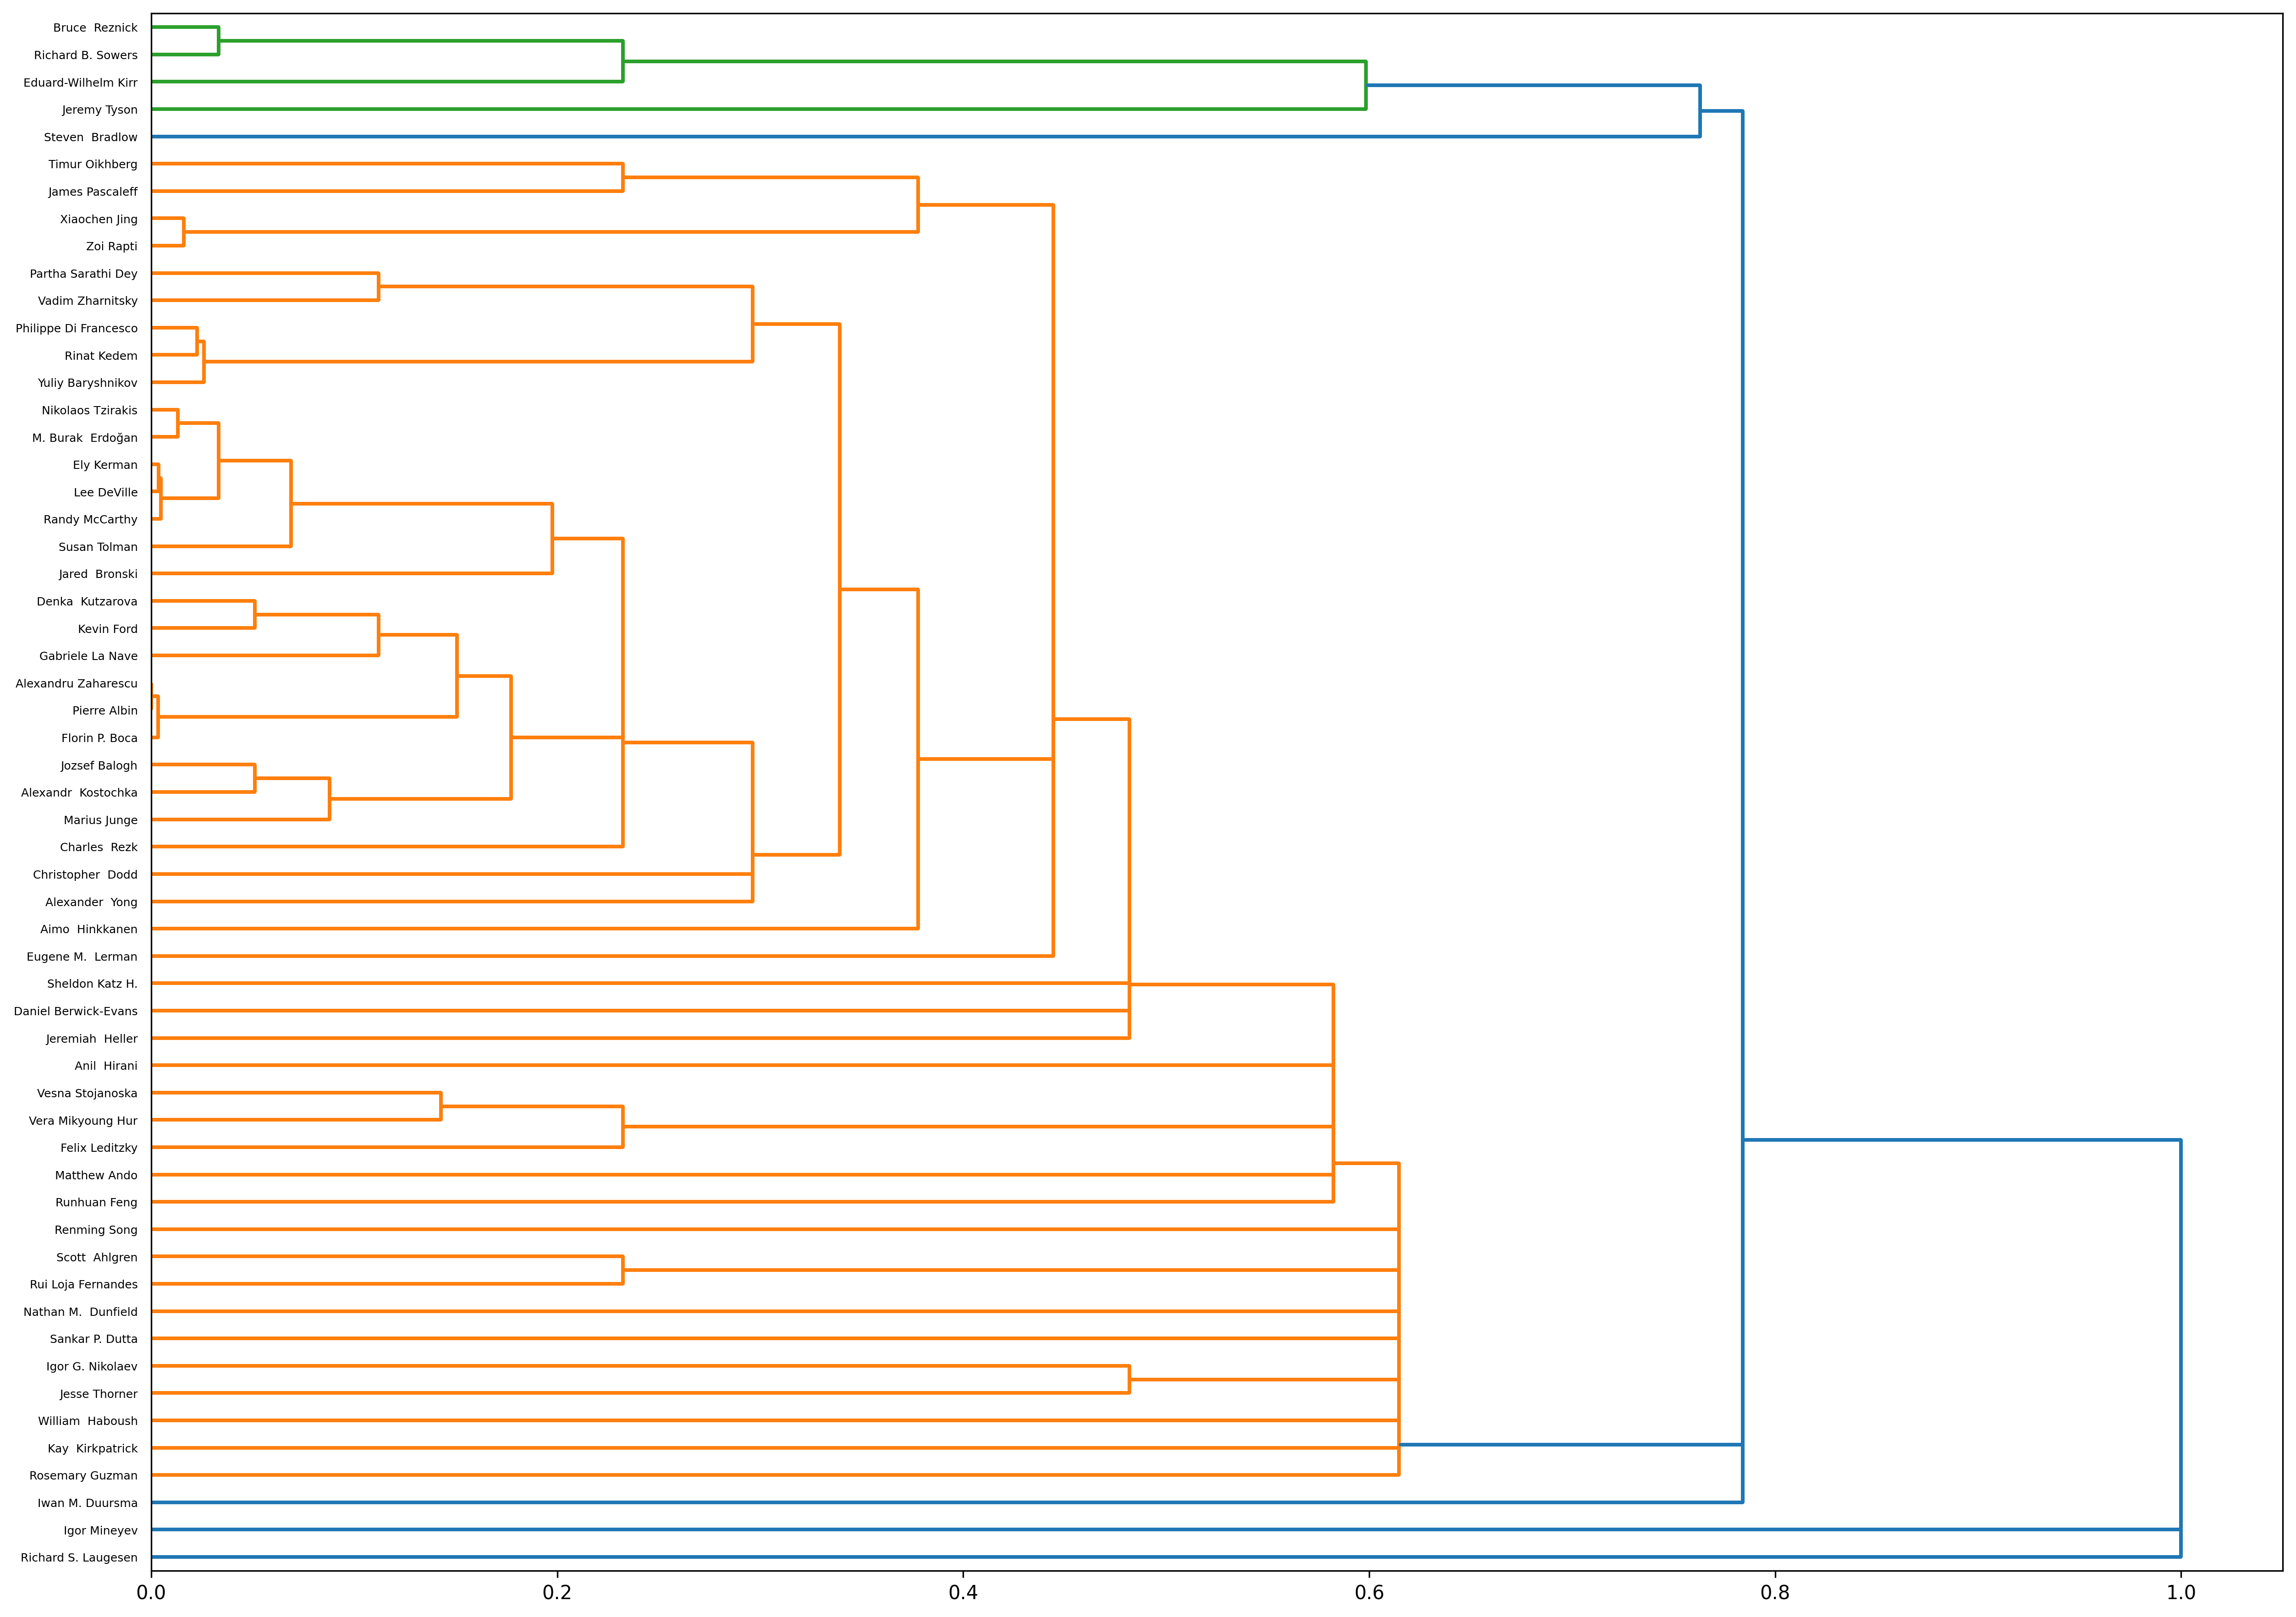

In [23]:
plot_dendrogram(d1(sim_pub_cite, 1.5), faculties, linkage="single")

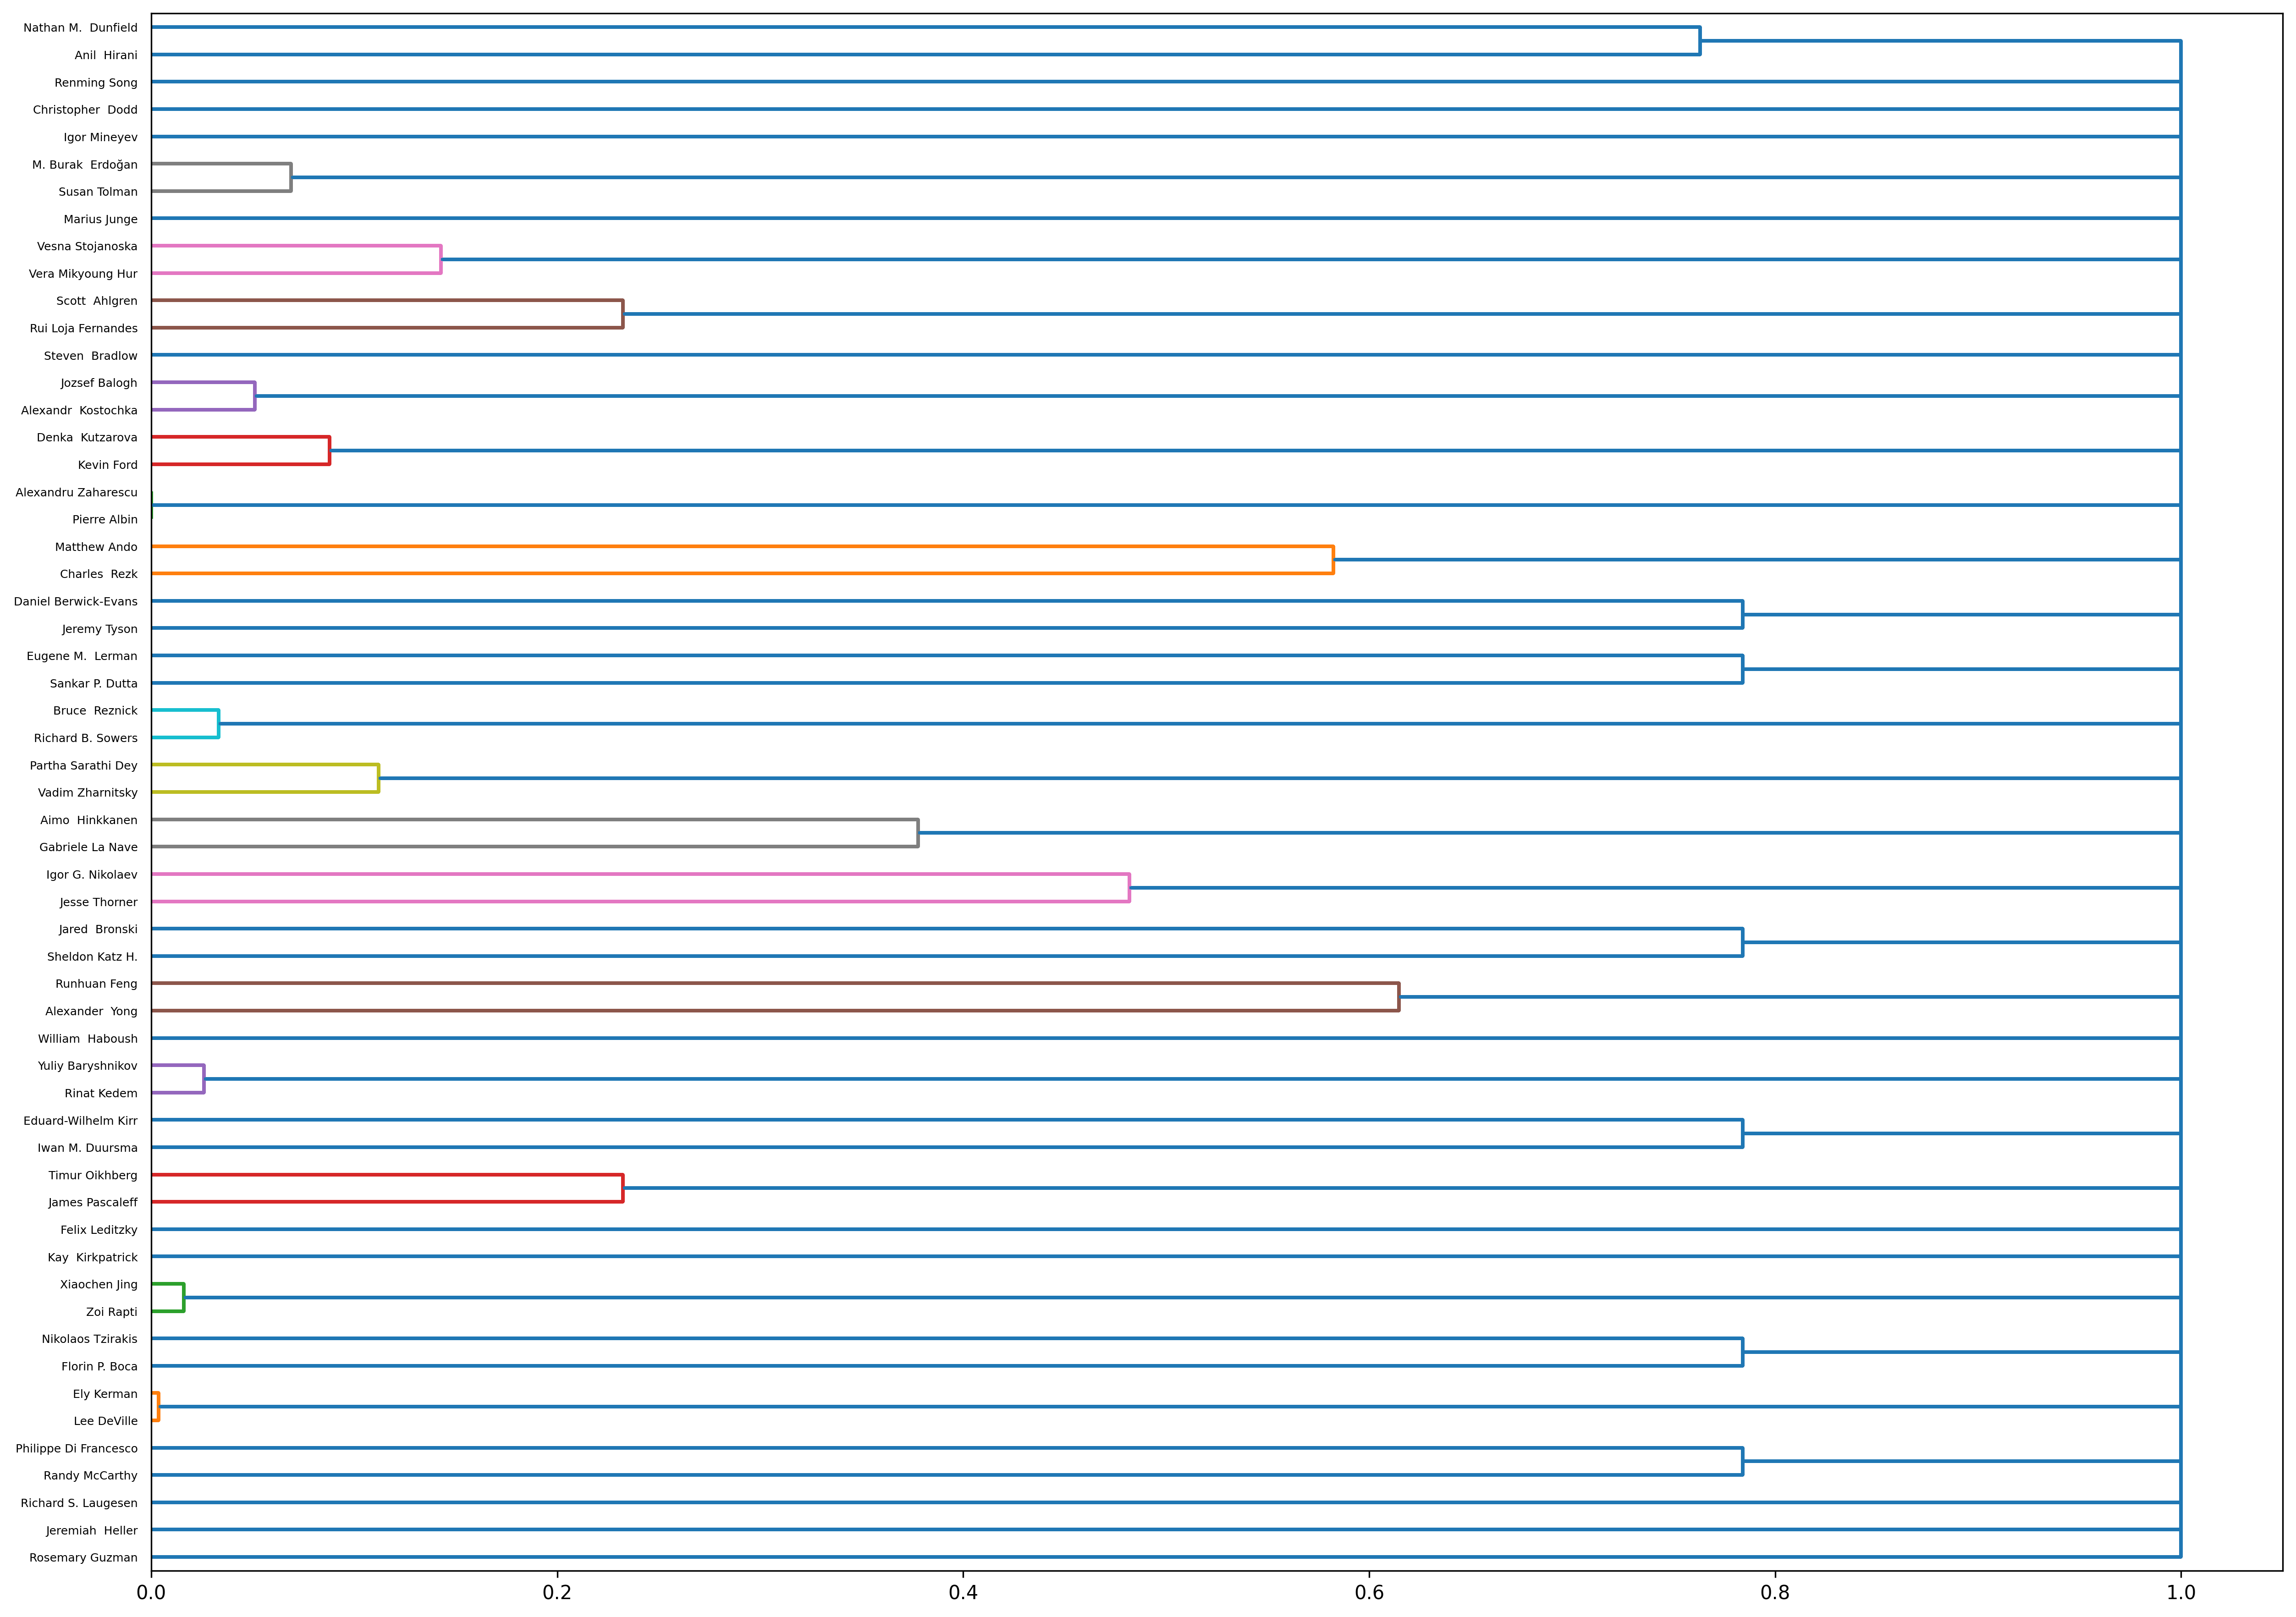

In [80]:
plot_dendrogram(d1(sim_pub_cite, 1.5), faculties, linkage="complete")

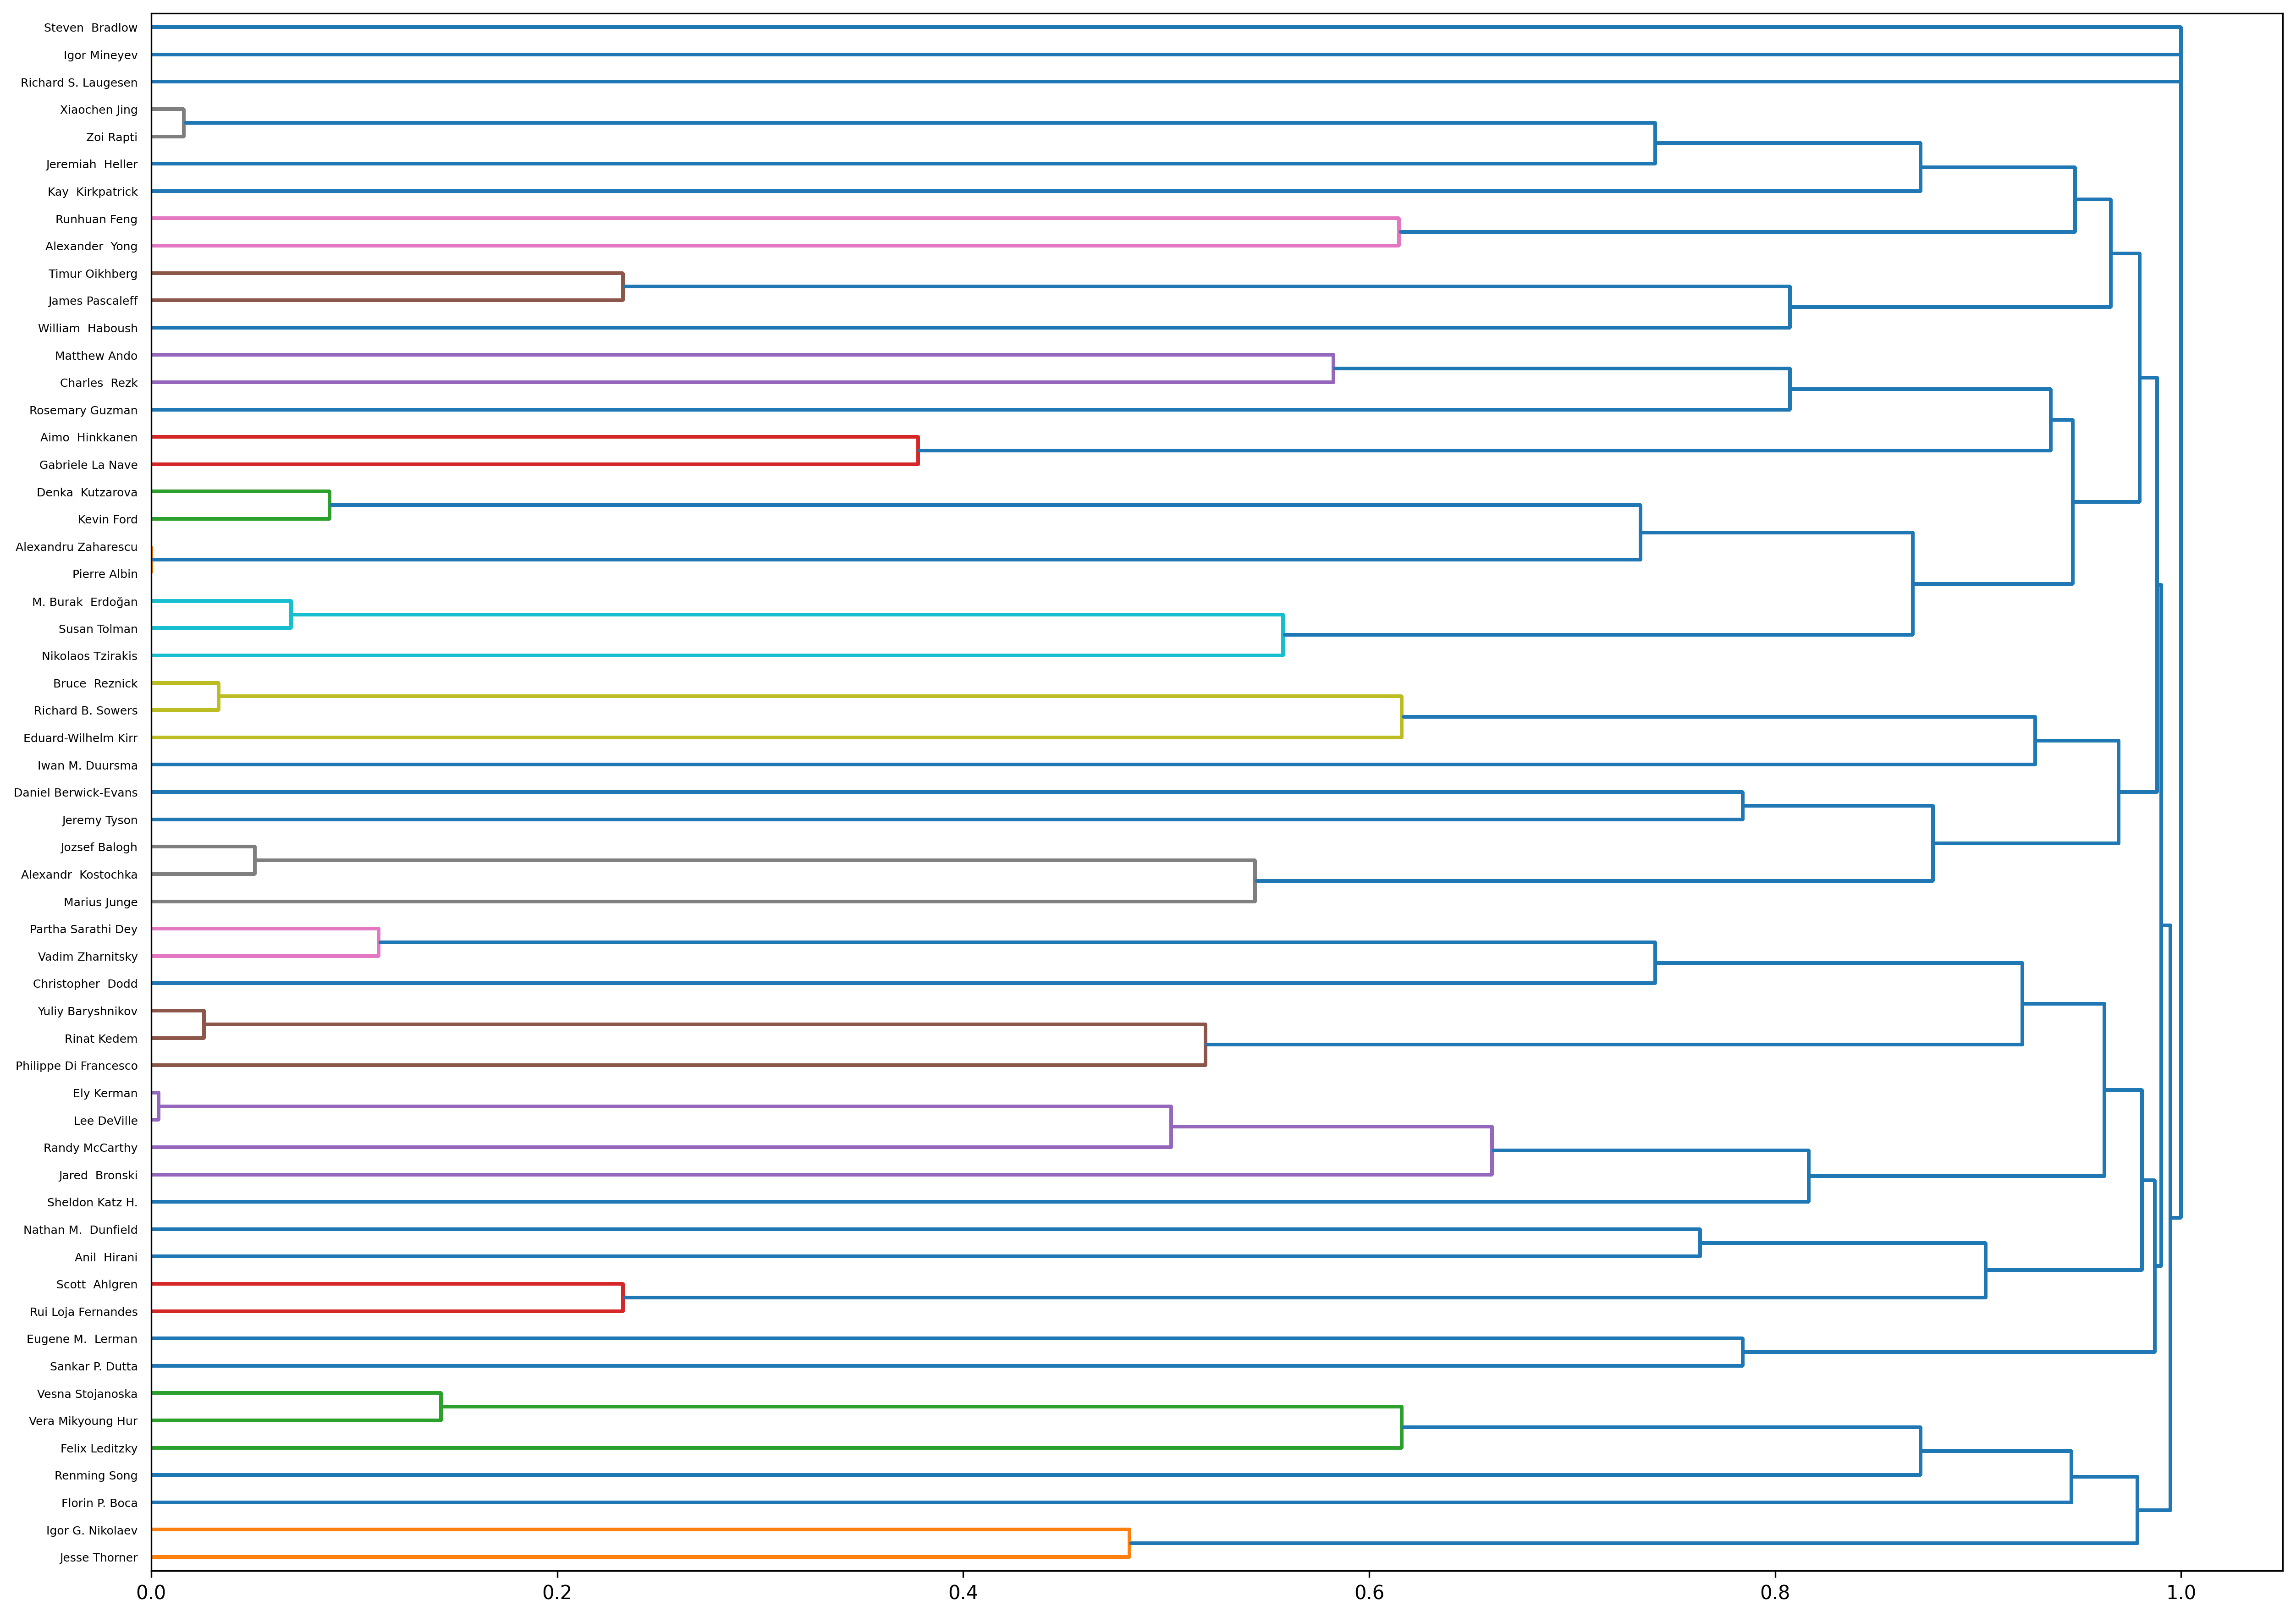

In [82]:
plot_dendrogram(d1(sim_pub_cite, 1.5), faculties, linkage="average")

# Clustering using # of Common Journal

**Number of Common Journal**

This data represents how many papers each pair of faculties published in same journals.

For example, if A published 3 papers in journal X and 4 papers in journal Y, while B published 2 papers in journal X and 5 papers in journal Y, then entry (A, B) of this dataset would be $3+2+4+5 = 14$.

In [30]:
f_com_journal = os.path.join(data_dir, "common_journals_.csv")
df_com_journals = pd.read_csv(f_com_journal)
sim_com_journals = df_com_journals[faculties].to_numpy()

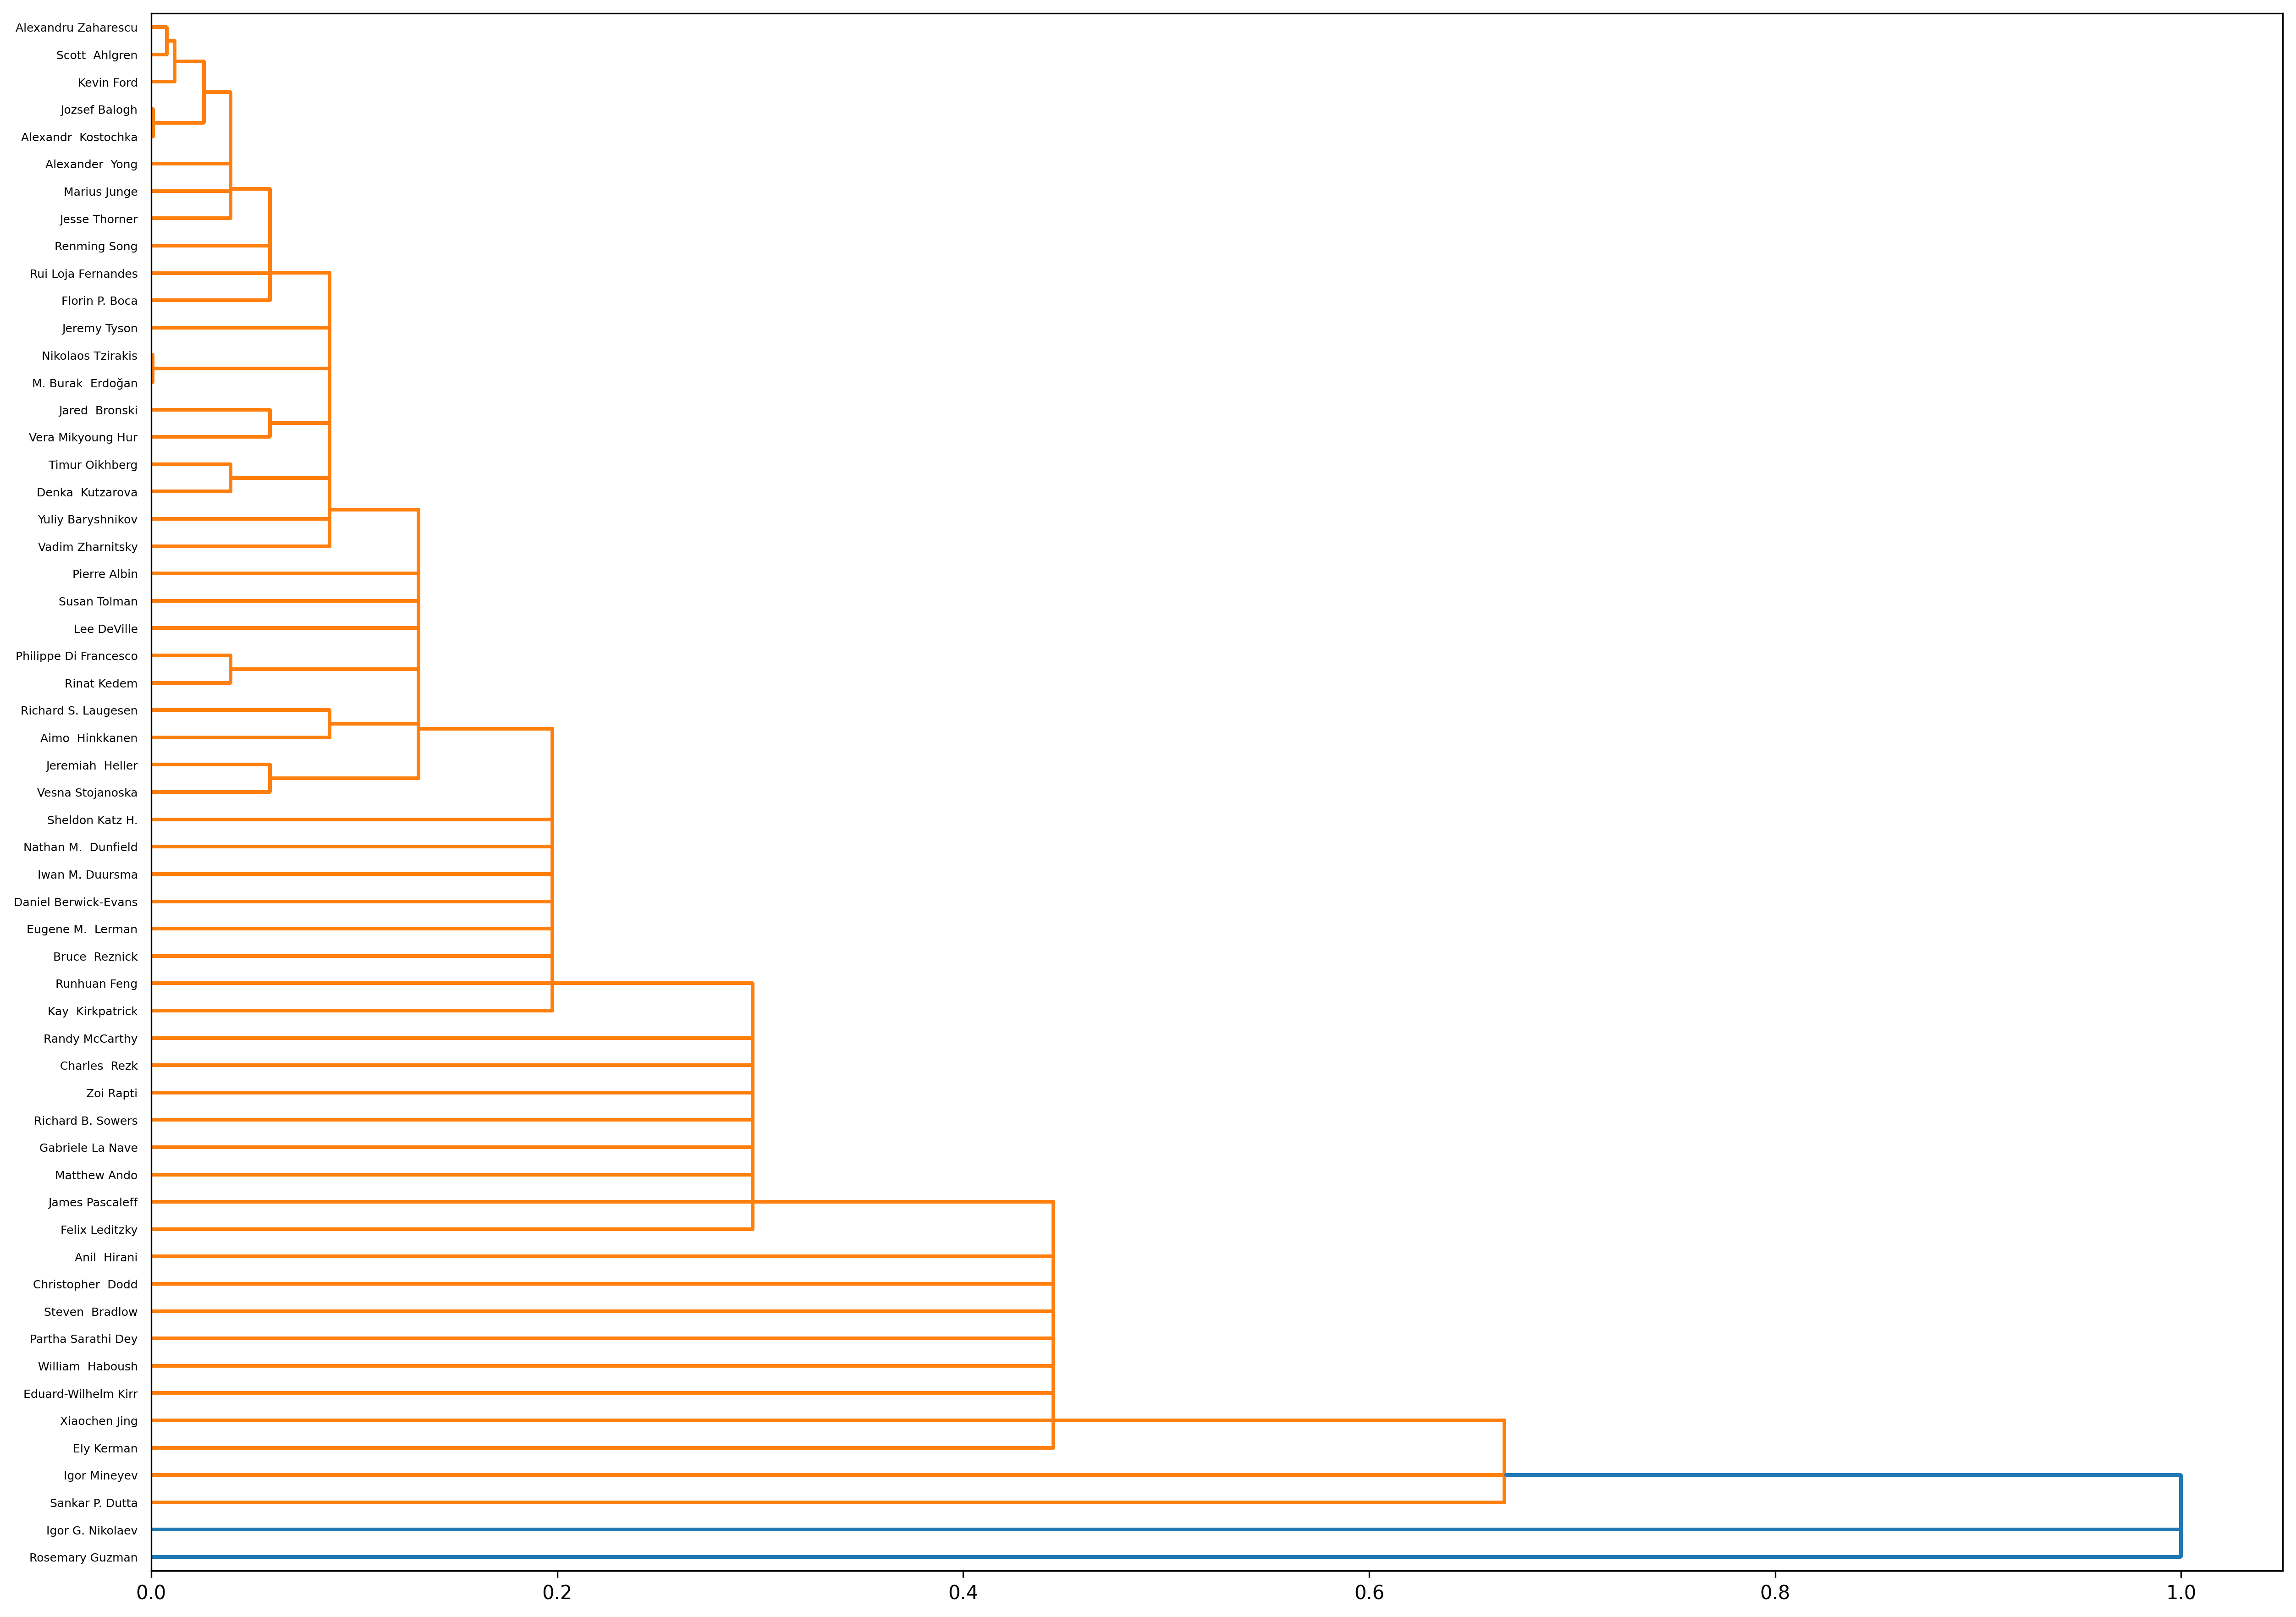

In [27]:
plot_dendrogram(d1(sim_com_journals, 1.5), faculties, linkage="single")

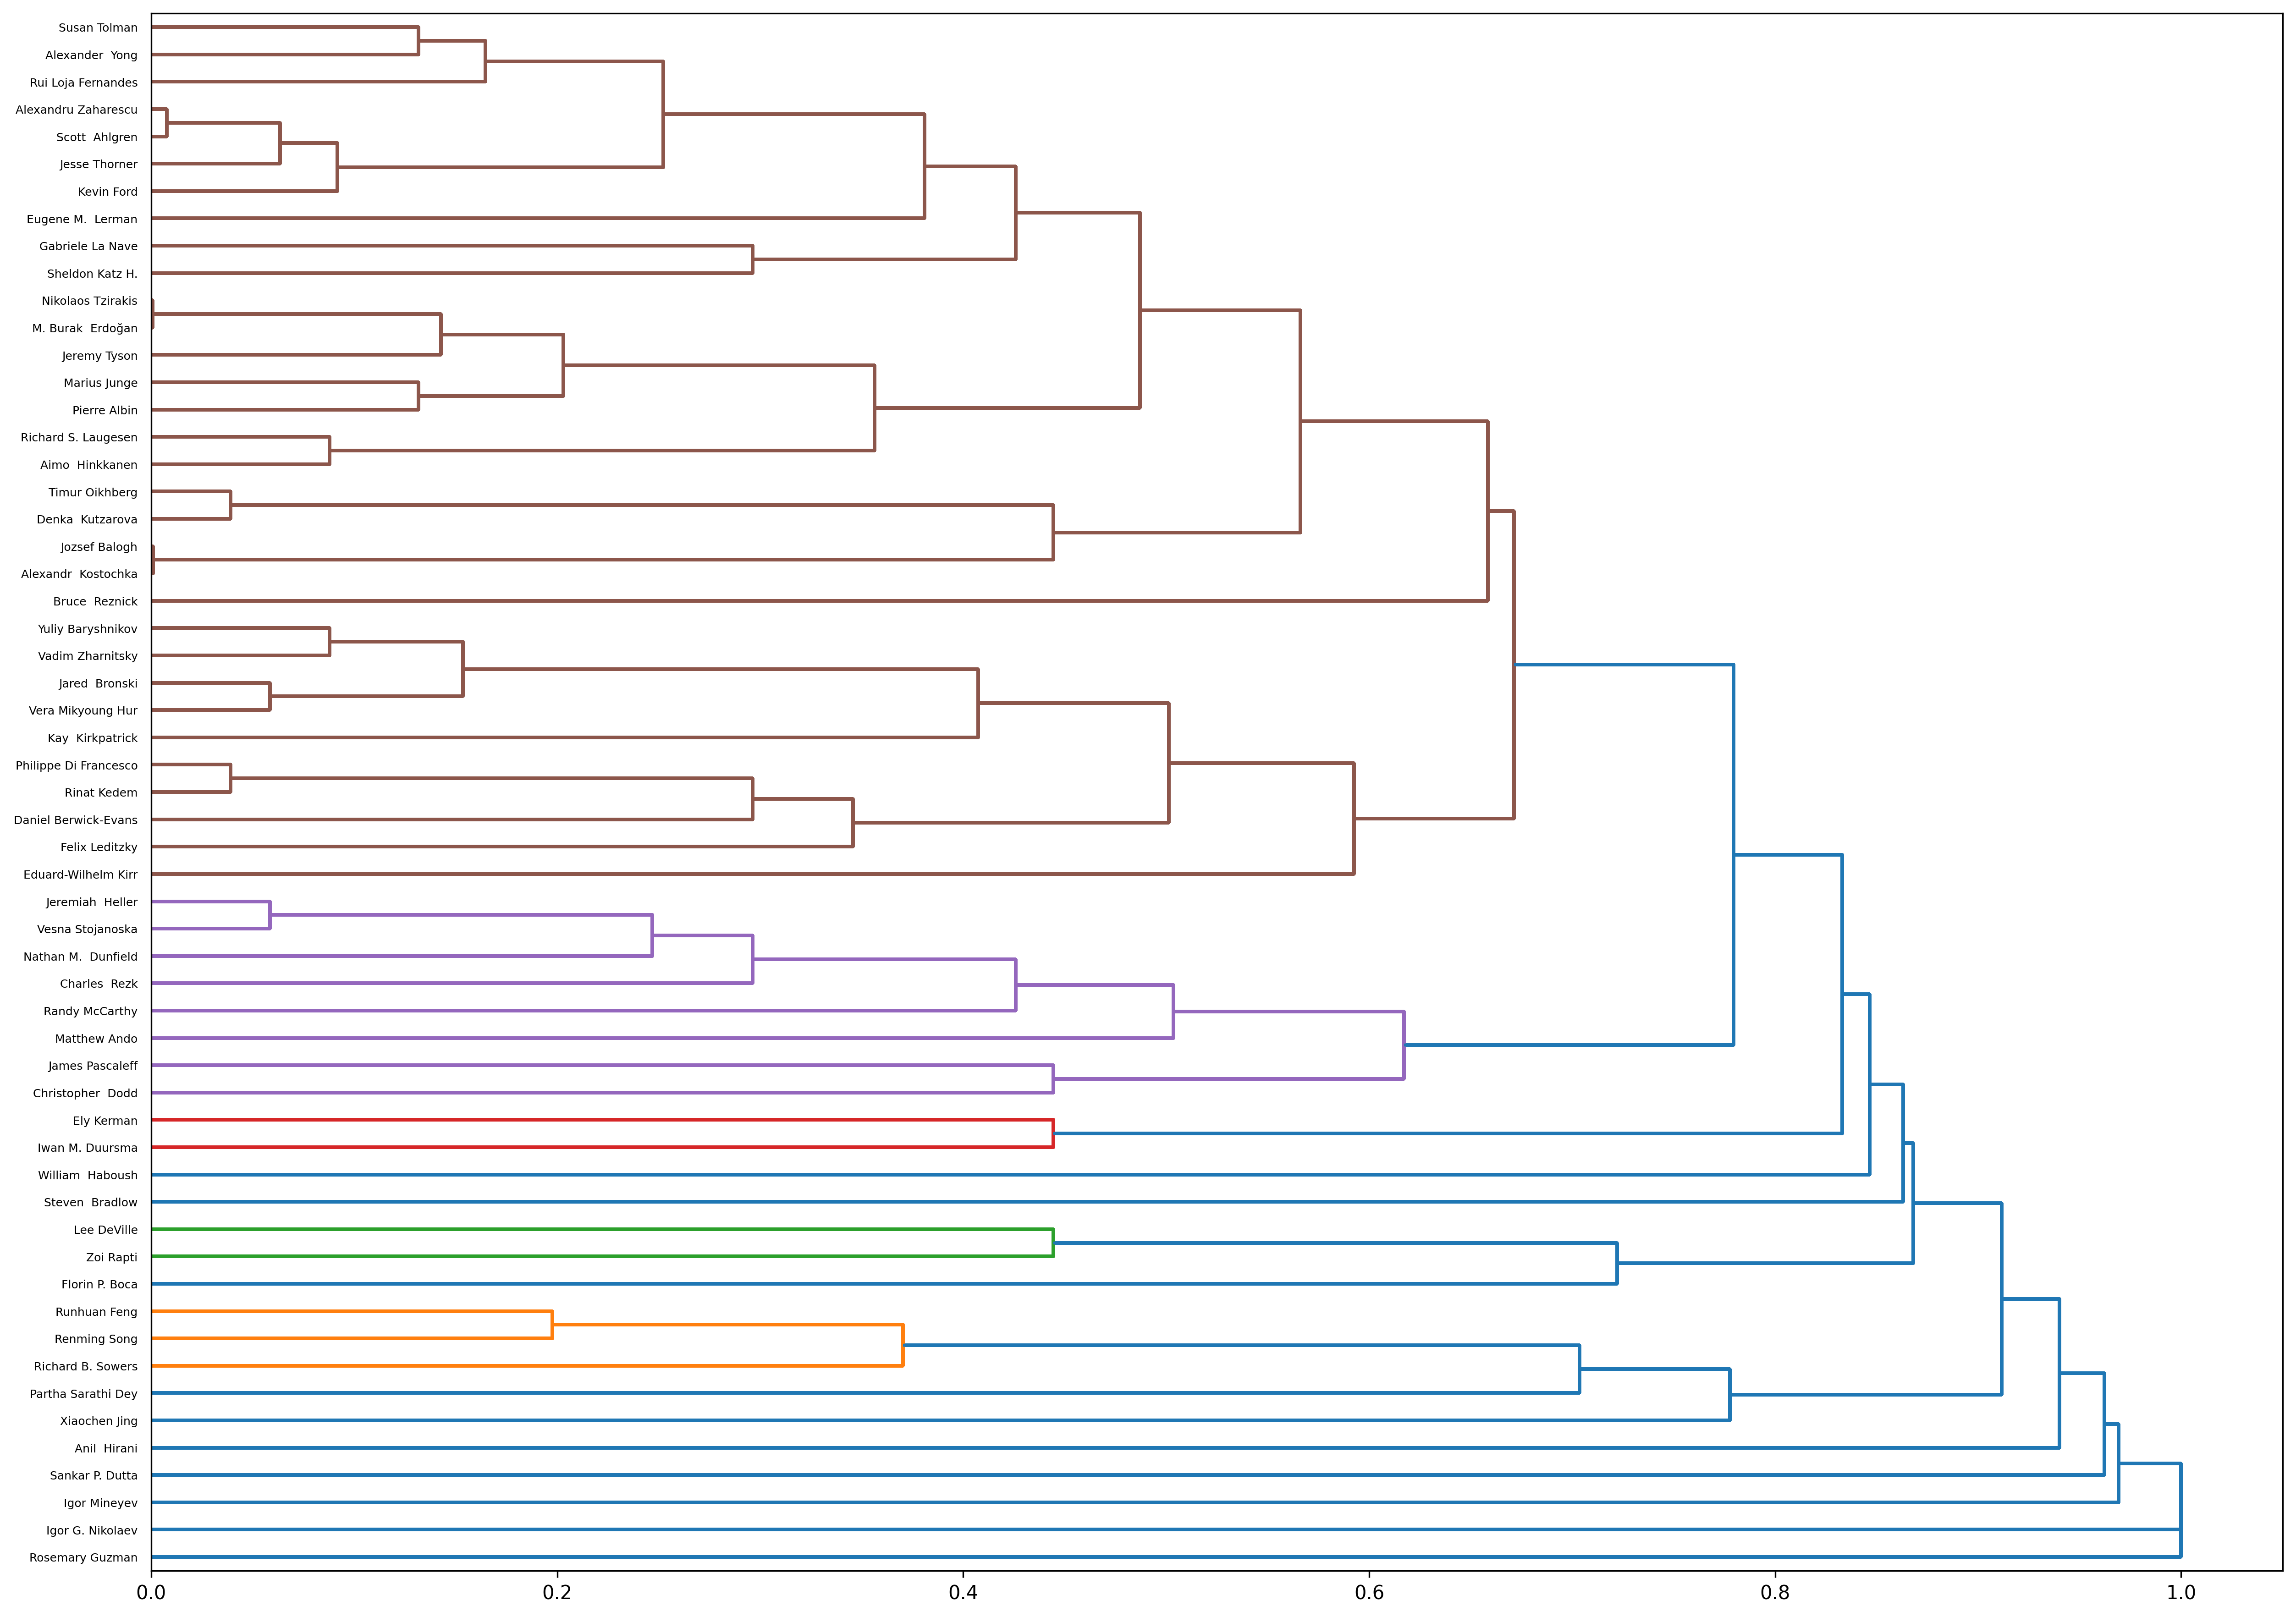

In [28]:
plot_dendrogram(d1(sim_com_journals, 1.5), faculties, linkage="average")

# Clustering with Common Reference


In [31]:
f_com_ref = os.path.join(data_dir, "common_references_.csv")
df_com_ref = pd.read_csv(f_com_ref)
sim_com_ref = df_com_ref[faculties].to_numpy()

TODO: Combining trees. Look up:

    bio.phylo.consensus
    
    SturmMean

# ------------------- Random stuff------------------

In [187]:
ncluster = 10

single = AgglomerativeClustering(n_clusters=ncluster, linkage="single", affinity="precomputed")
labels_single = single.fit(distance_mat).labels_

complete = AgglomerativeClustering(n_clusters=ncluster, linkage="complete", affinity="precomputed")
labels_complete = complete.fit(distance_mat).labels_

average = AgglomerativeClustering(n_clusters=ncluster, linkage="average", affinity="precomputed")
labels_average = average.fit(distance_mat).labels_

# labels_single = dict(zip(faculties, labels_single))
# labels_complete = dict(zip(faculties, labels_complete))
# labels_average = dict(zip(faculties, labels_average))

In [182]:
labels_complete

array([0, 0, 2, 4, 7, 2, 0, 3, 0, 7, 0, 1, 1, 3, 7, 4, 7, 3, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 7, 1, 3, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1, 0, 6,
       4, 0, 0, 0, 0, 7, 6, 2, 3, 3, 4, 1, 5])

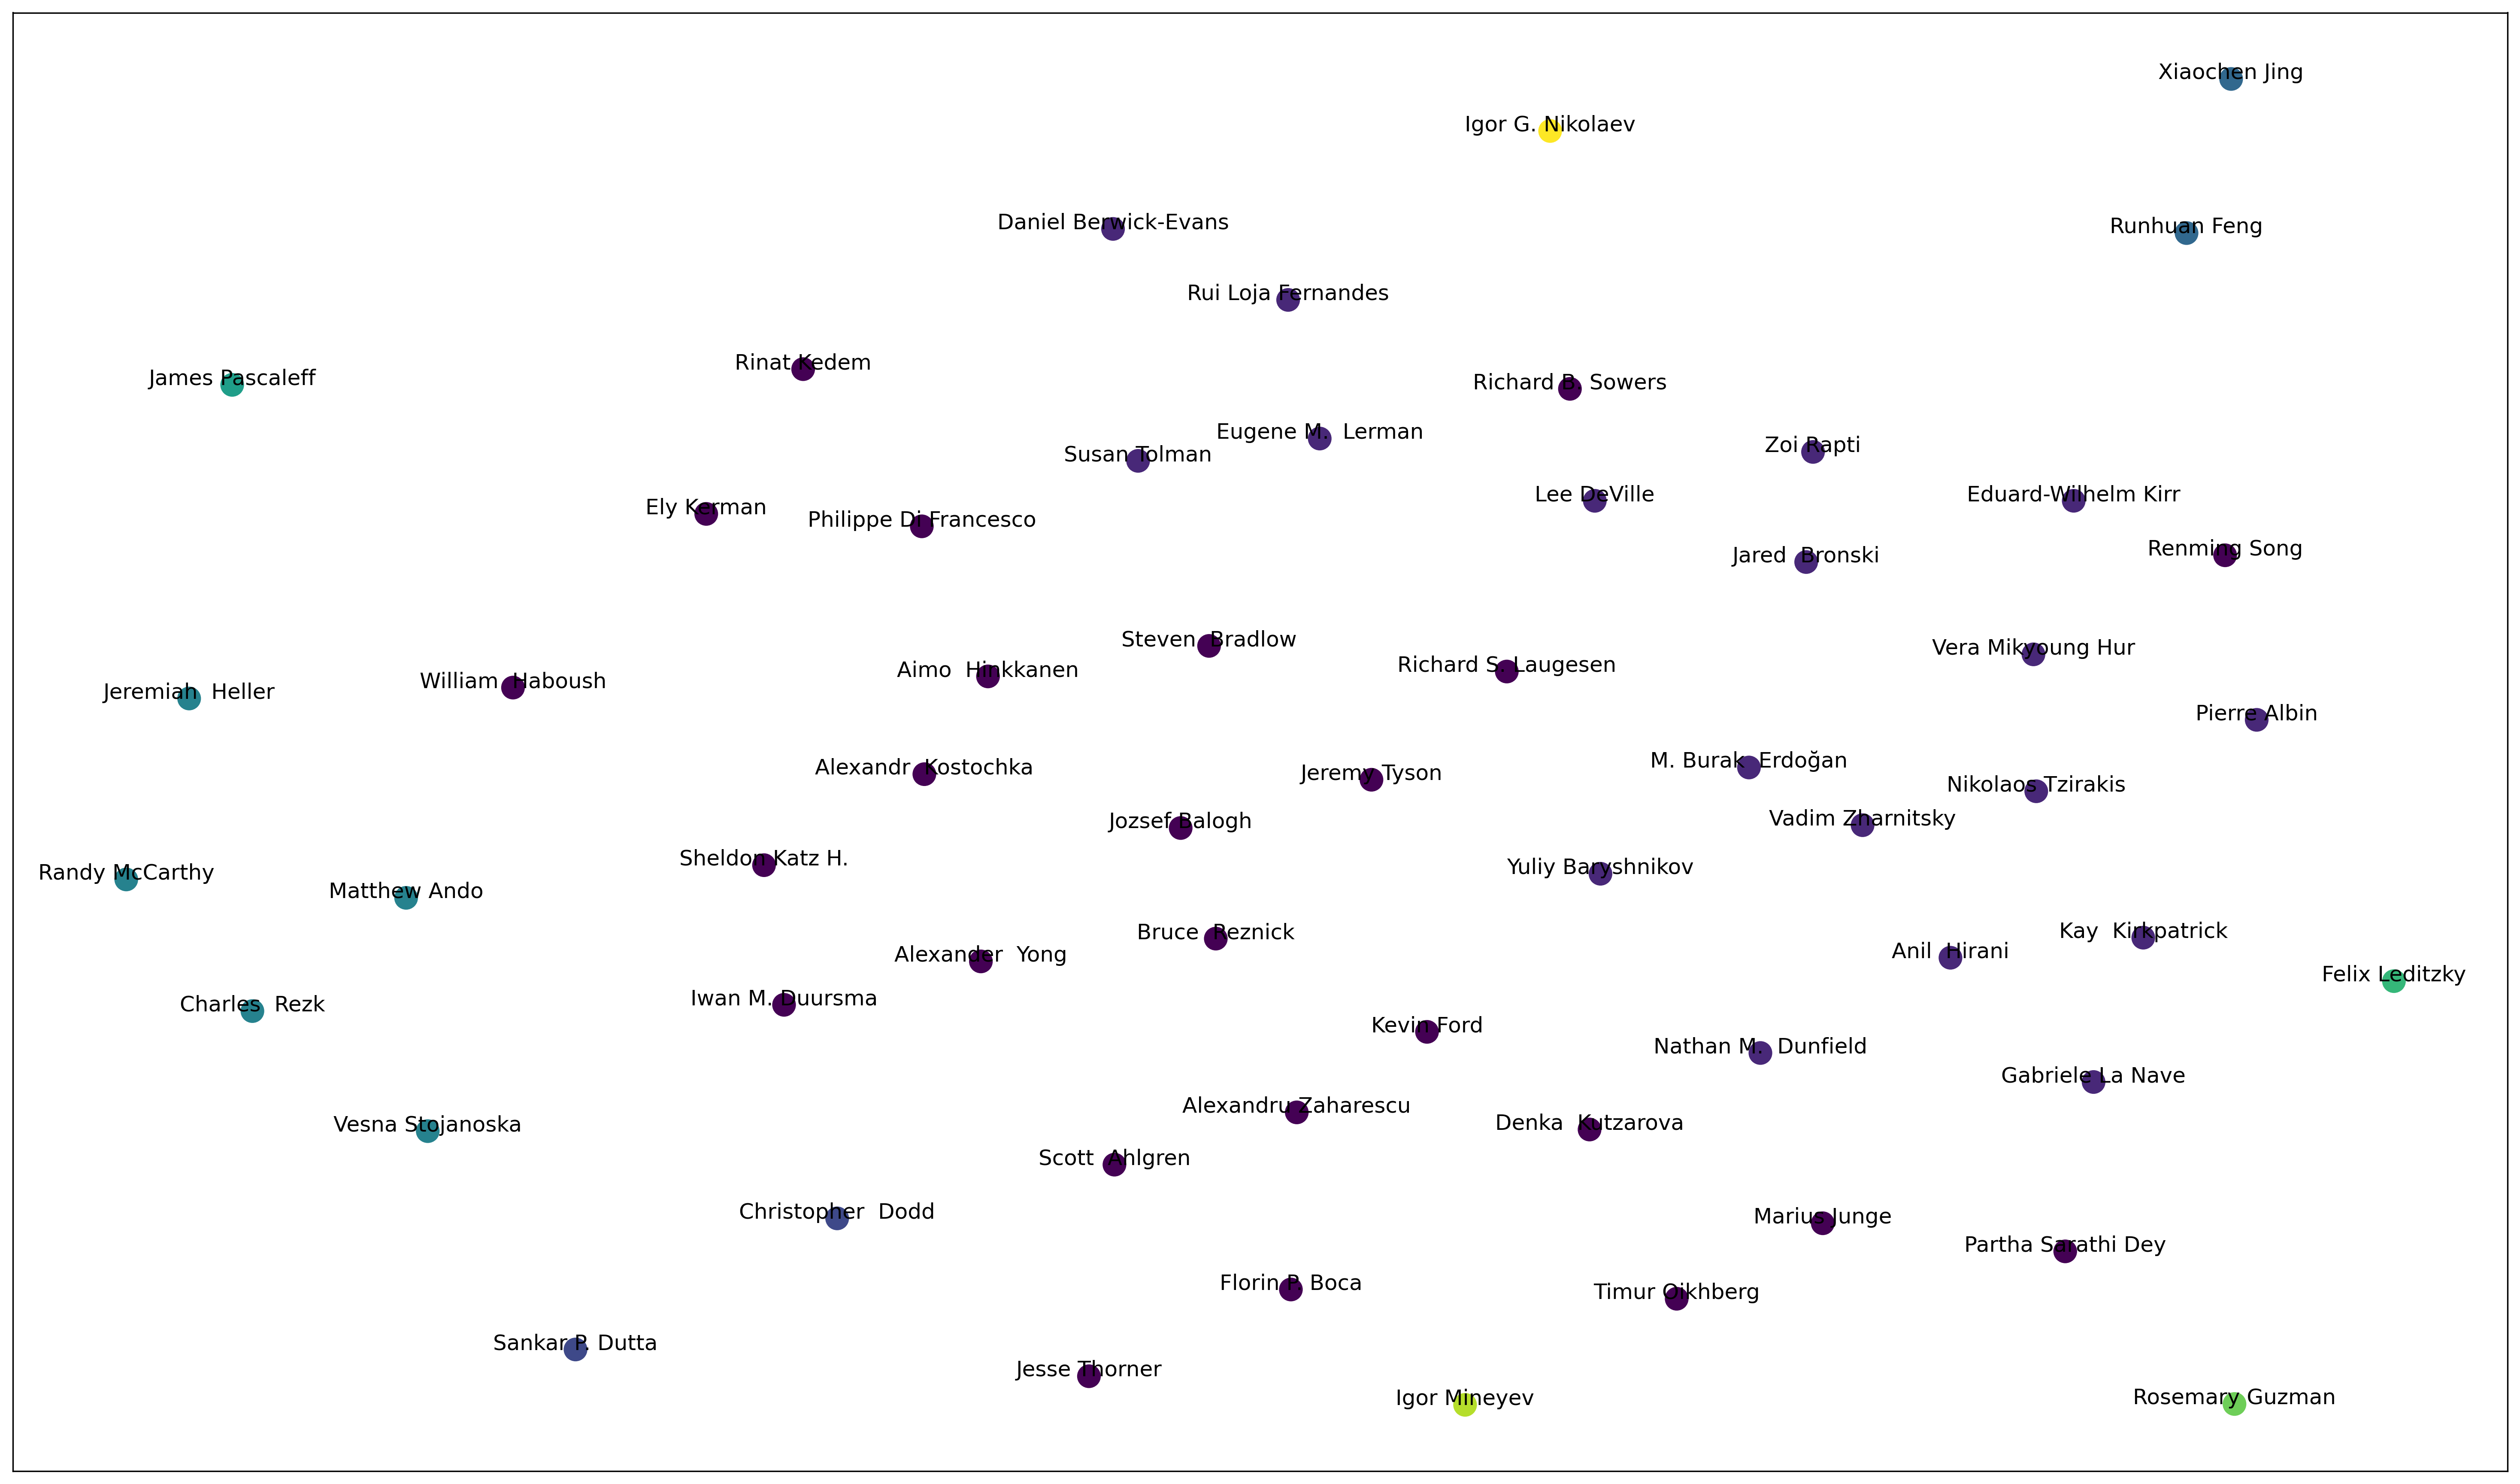

In [209]:
similarity_mat = distance_mat.copy()
np.fill_diagonal(similarity_mat, 1)
similarity_mat = 1/similarity_mat
np.fill_diagonal(similarity_mat, 0)

G = nx.from_numpy_array(similarity_mat ** 3)
nx.set_node_attributes(G, {i: faculties[i] for i in range(len(faculties))}, "name")
plt.figure(figsize=(25,15), dpi=300)
pos = nx.spring_layout(G, weight = "weight")
nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=labels_average)
nx.draw_networkx_labels(G, pos=pos,
                        labels={i: faculties[i] for i in range(len(faculties))},
                        font_size=12, verticalalignment="baseline")
plt.savefig("graph.jpg")
plt.show()


In [142]:
np.fill_diagonal(distance_mat, 1)
distance_mat

array([[1., 3., 4., ..., 3., 4., 5.],
       [3., 1., 4., ..., 3., 5., 5.],
       [4., 4., 1., ..., 4., 6., 4.],
       ...,
       [3., 3., 4., ..., 1., 5., 6.],
       [4., 5., 6., ..., 5., 1., 5.],
       [5., 5., 4., ..., 6., 5., 1.]])